# Time Series Analysis

In [1]:
#import libraries
import numpy as np
import pandas as pd

import yfinance as yf
from yahoofinancials import YahooFinancials

#importing required libraries for ARIMA, auto_Arima
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima

from math import sqrt
from sklearn.metrics import mean_squared_error
import scipy.stats as stats

#importing libraries for Exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt

from pandas.tseries.offsets import DateOffset

#data visualisation
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import seaborn as sns
plt.style.use('seaborn')
import cufflinks as cf



# figure will appear below the cell that generated it
%matplotlib inline 
%config InlineBackend.figure_format = 'retina' #improve plot visualisation

import warnings
warnings.filterwarnings("ignore") #is a built-in module of Python that handles the warning messages

In [2]:
#download market data using yfinance API

stock_data = yf.download(tickers = 'JPM C GS MS UBS BCS', period = '4y',
                  interval = '1d', actions = 'inline')

#actions = 'inline' #additionally download dividends and stock splits

[*********************100%***********************]  6 of 6 completed


# Part I

In this part of my project, I will perform an exploratory data analysis of investment banks like J.P Morgan, Goldman Sachs, Citigroup, Morgan Stanley, UBS, and Barclays. Visualize daily traded Volume, Volatility, and Market Capitalisation.

Data description:
* Open: The price of the stock when the market opens in the morning
* Close: The price of the stock when the market closed in the evening
* High: Highest price the stock reached during that day
* Low: Lowest price the stock is traded on that day
* Volume: The total amount of stocks traded on that day

In [3]:
#check for missing data
stocks_adj_close_price = stock_data['Adj Close'].copy()
stocks_adj_close_price.isnull().sum()

BCS    0
C      0
GS     0
JPM    0
MS     0
UBS    0
dtype: int64

In [4]:
#In case there are missing data I choose 'bfill' method such as the next stock price is always dependent on a previous value
#stocks_adj_close_price.fillna(method='bfill')

In [5]:
stocks_adj_close_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1007 entries, 2018-05-29 to 2022-05-25
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BCS     1007 non-null   float64
 1   C       1007 non-null   float64
 2   GS      1007 non-null   float64
 3   JPM     1007 non-null   float64
 4   MS      1007 non-null   float64
 5   UBS     1007 non-null   float64
dtypes: float64(6)
memory usage: 55.1 KB


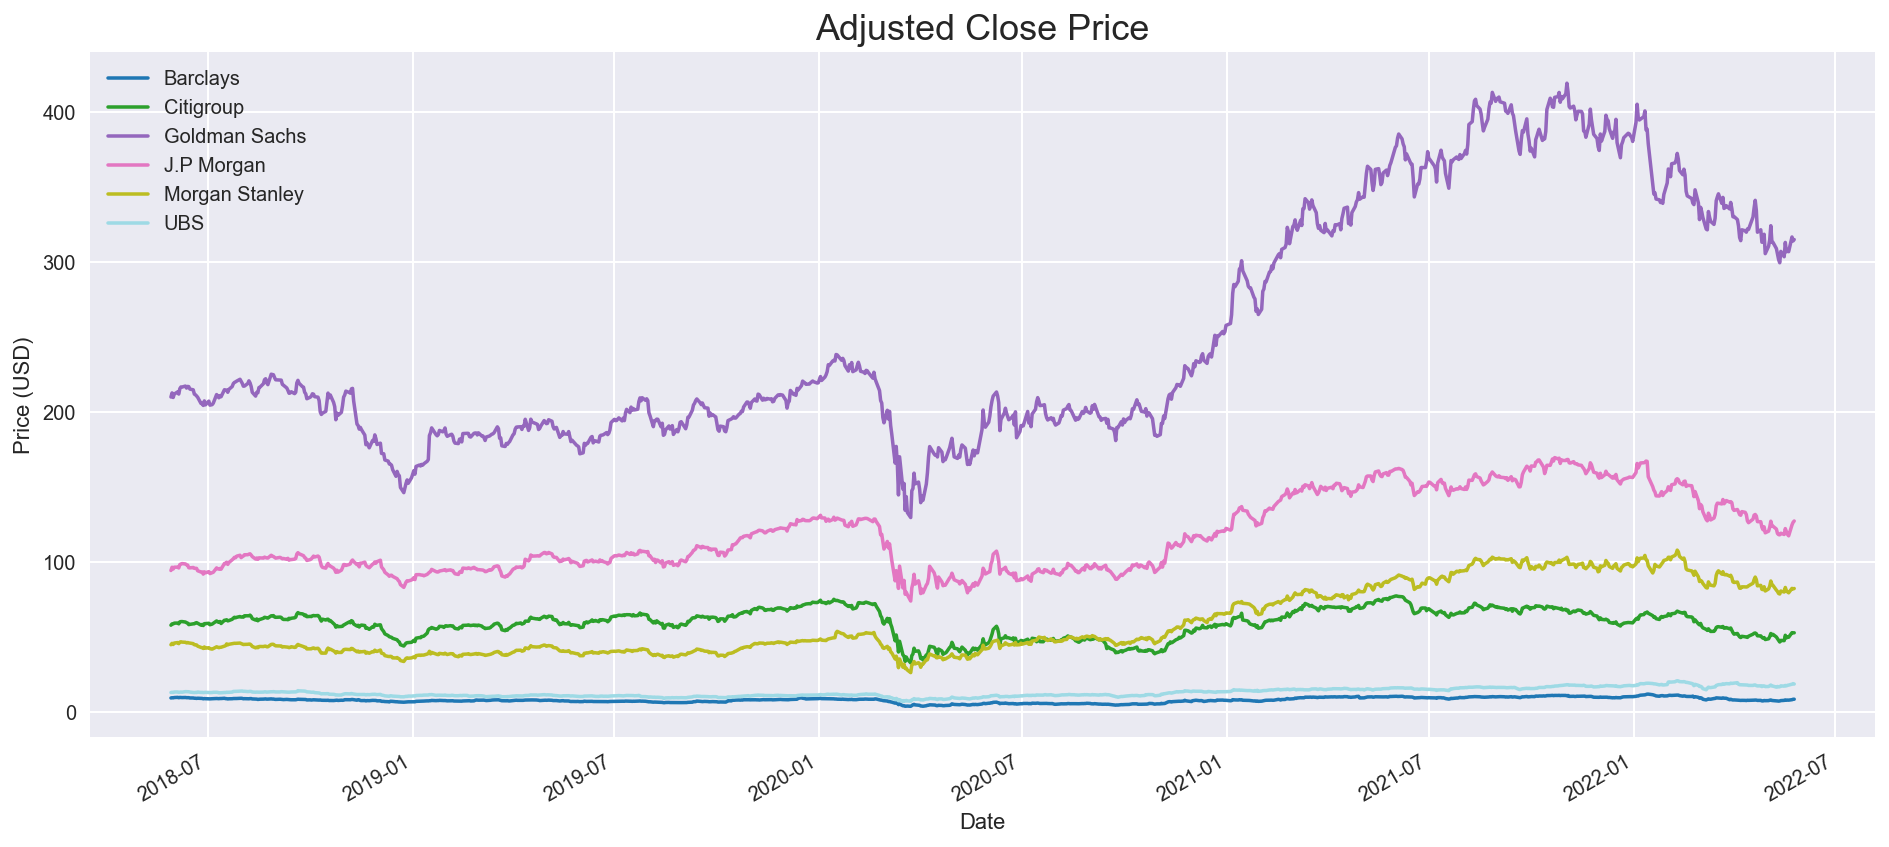

In [6]:
#rename columns
stocks_adj_close_price.rename(columns = {
    'BCS': 'Barclays', 'C': 'Citigroup', 
    'GS': 'Goldman Sachs', 'MS': 'Morgan Stanley',
    'JPM': 'J.P Morgan'},inplace = True)
#visualize
stocks_adj_close_price.plot(figsize = (16,7), colormap = 'tab20')
plt.title('Adjusted Close Price', fontdict = {'fontsize': 18})
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show()

We can observe that the absolute prices of Goldman Sachs are higher when comparing it to other investment banks. 

In [7]:
#summary statistics
stocks_adj_close_price.describe().round(2)


Barclays  Citigroup  Goldman Sachs  J.P Morgan  Morgan Stanley      UBS
count   1007.00    1007.00        1007.00     1007.00         1007.00  1007.00
mean       7.87      59.23         252.11      118.04           59.30    12.95
std        1.72       9.31          78.94       25.30           23.05     2.91
min        3.69      32.63         129.55       73.88           26.13     6.83
25%        6.88      54.32         192.31       96.39           40.63    10.68
50%        7.84      60.47         212.16      107.65           46.90    11.78
75%        9.27      66.16         328.53      144.08           82.00    15.19
max       11.82      77.29         419.15      169.50          107.80    20.72

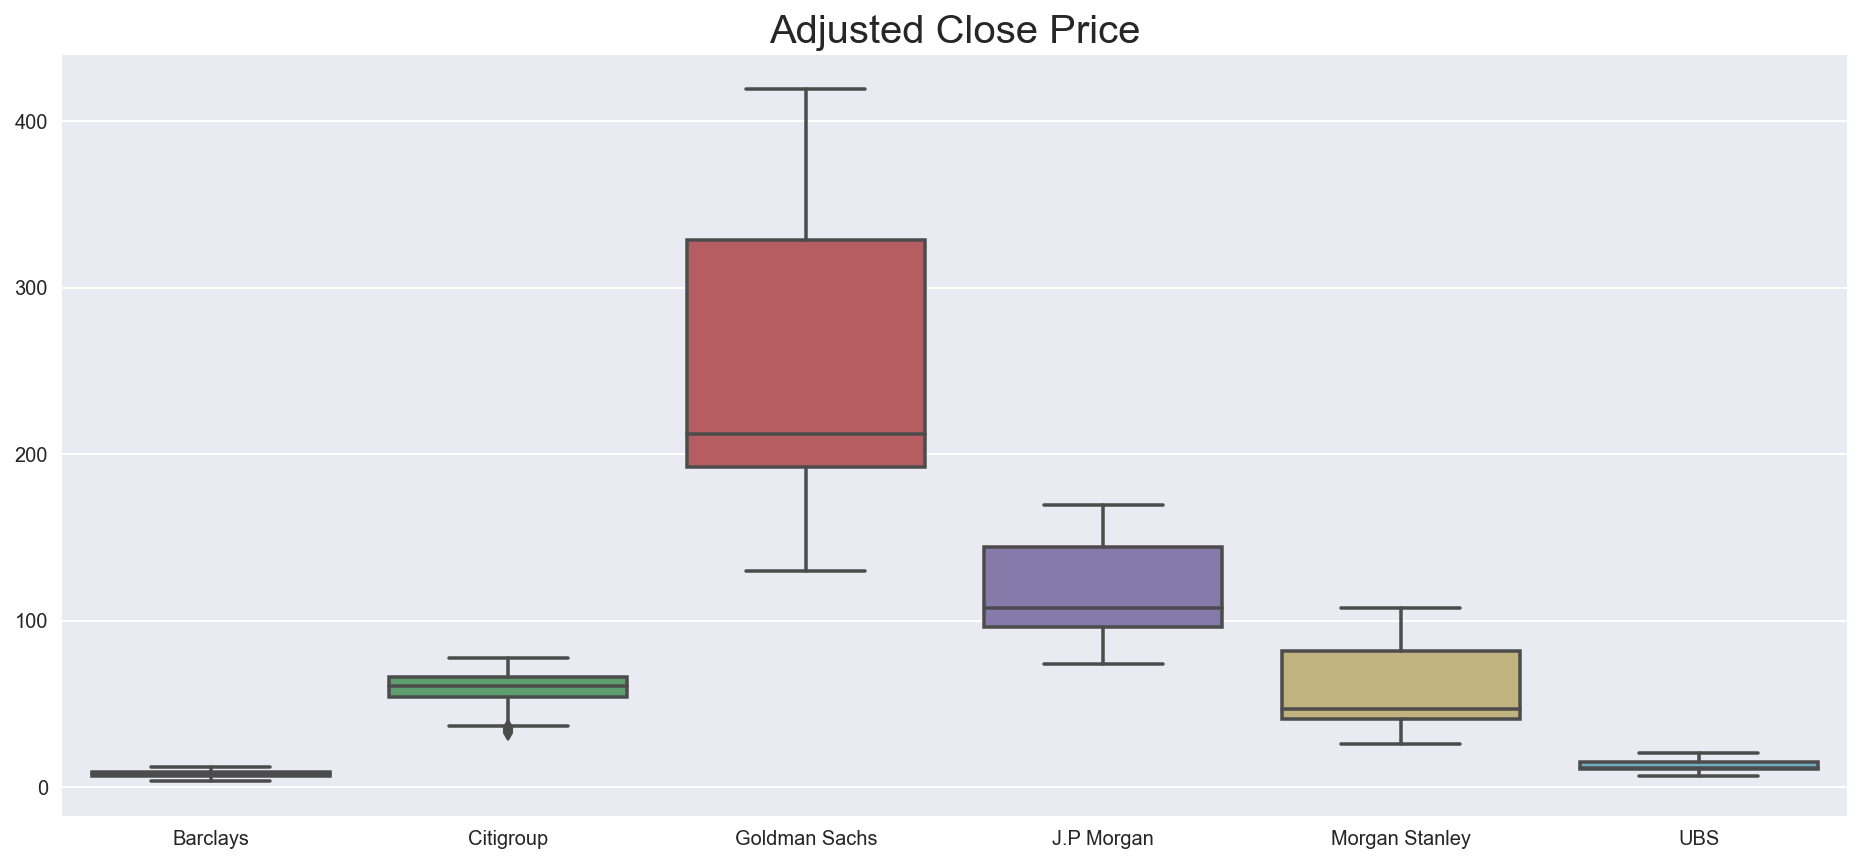

In [8]:
plt.figure(figsize = (16,7))
sns.boxplot(data = stocks_adj_close_price)
plt.title('Adjusted Close Price', fontdict={'fontsize': 20});

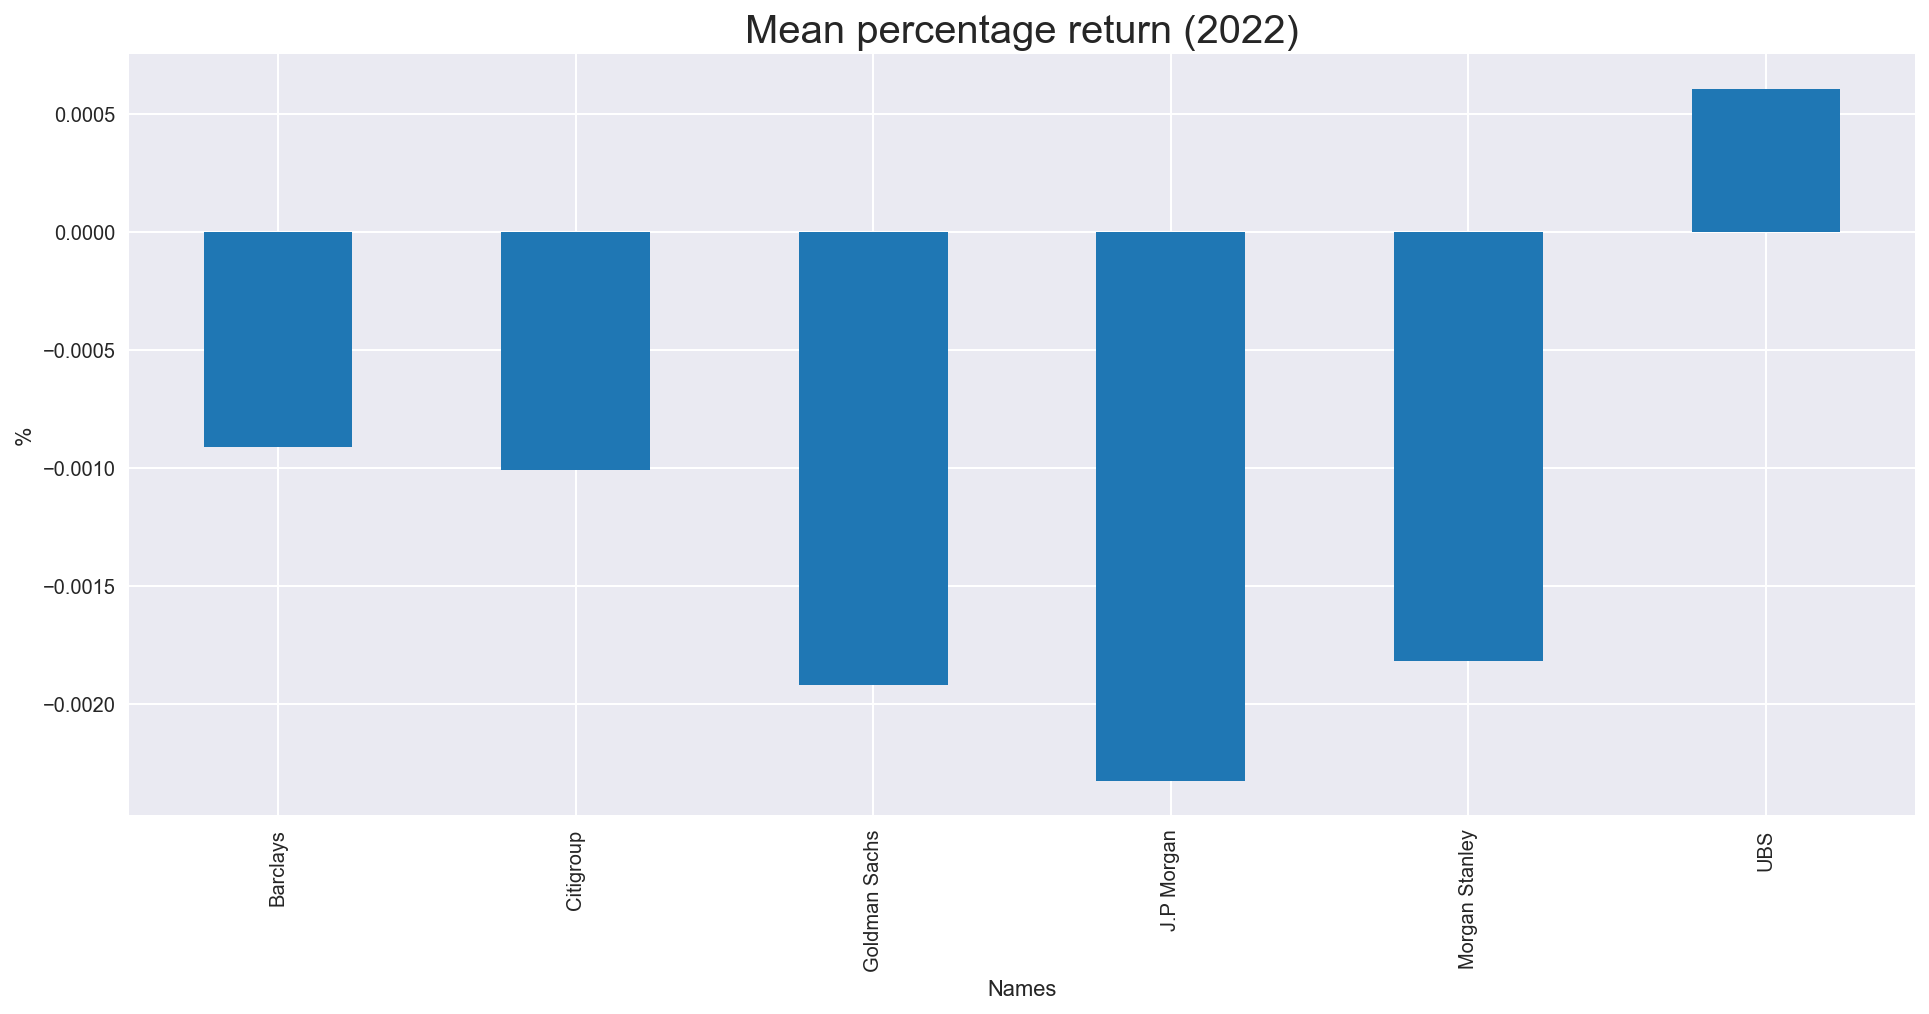

In [9]:
stocks_adj_close_price.loc['2022-01-01':].pct_change().round(2).mean().plot(kind = 'bar', figsize = (16,7), colormap = 'tab20')
plt.title('Mean percentage return (2022)',fontdict = {'fontsize': 20})
plt.xlabel('Names')
plt.ylabel('%');

It is better to calculate return on adjusted price as it reflects that stock's value after accounting for corporate actions like dividend-paying and stock splits.

In [10]:
returns_df= np.log(stocks_adj_close_price/stocks_adj_close_price.shift(1))
returns_all = returns_df*100
returns_all.dropna(inplace = True)
returns_all.describe()

Barclays    Citigroup  Goldman Sachs   J.P Morgan  Morgan Stanley  \
count  1006.000000  1006.000000    1006.000000  1006.000000     1006.000000   
mean     -0.009347    -0.009118       0.040312     0.029848        0.060475   
std       2.704942     2.567027       2.158222     2.096525        2.315662   
min     -24.656386   -21.441431     -13.588045   -16.210576      -16.960270   
25%      -1.161228    -1.082718      -0.958551    -0.865436       -1.072908   
50%       0.000000     0.013819       0.012815     0.000000        0.062906   
75%       1.159070     1.123710       1.120353     0.949855        1.179276   
max      17.248645    16.538149      16.195138    16.562034       18.040332   

               UBS  
count  1006.000000  
mean      0.036162  
std       2.053555  
min     -17.026646  
25%      -0.921719  
50%       0.054872  
75%       0.984009  
max      12.590730

Text(0.5, 0, 'Time')

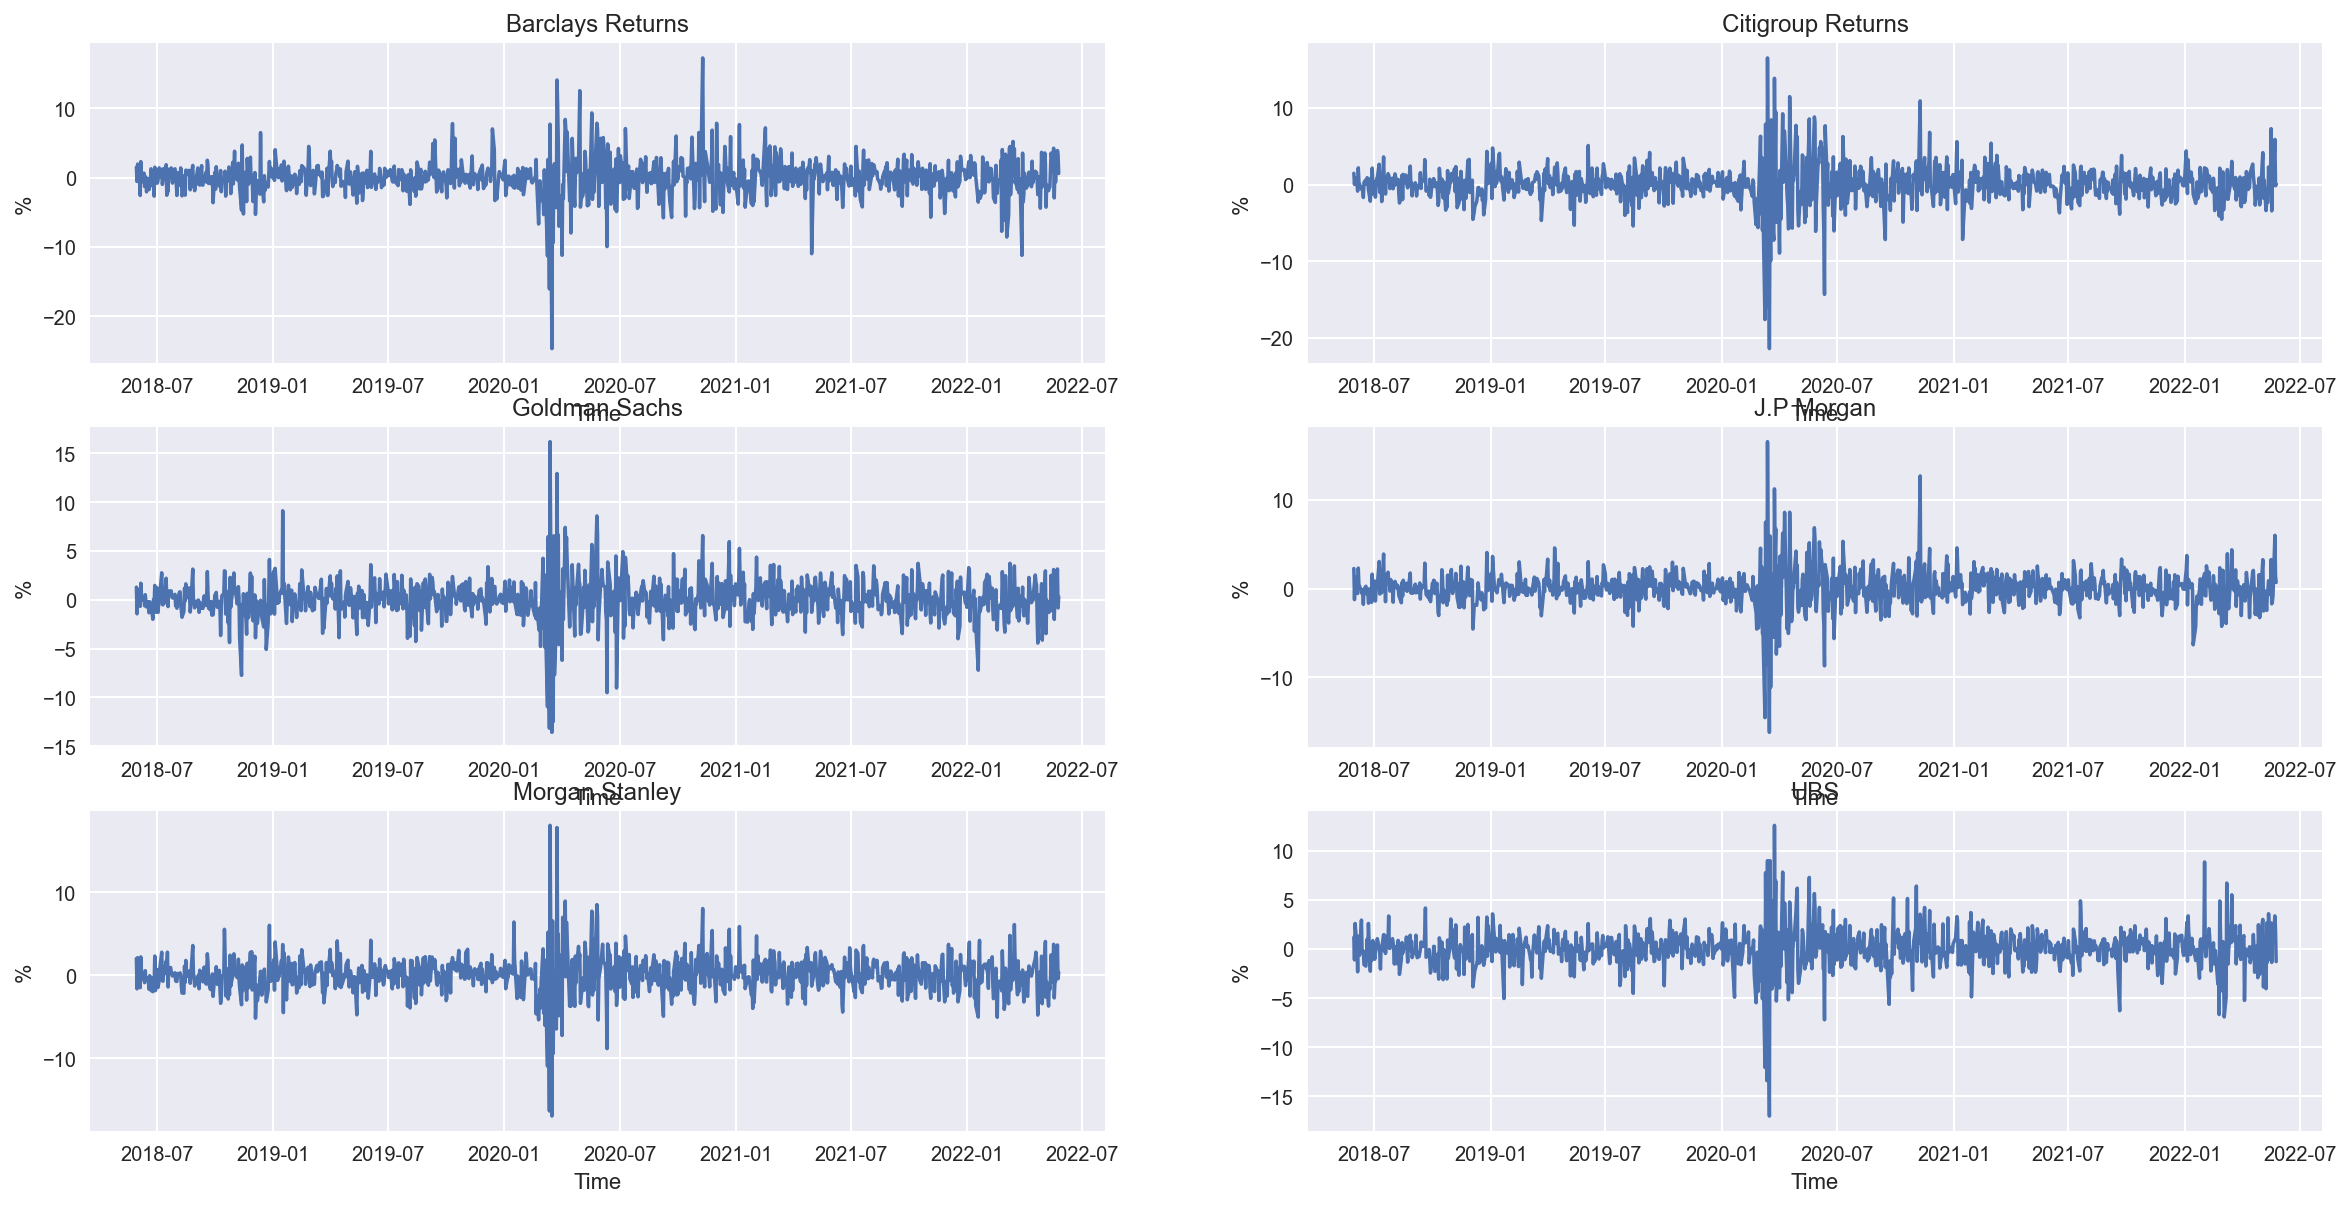

In [11]:
plt.figure(figsize=(20,10))
plt.subplot(3,2,1)
plt.plot(returns_all['Barclays'])
plt.ylabel('%')
plt.title('Barclays Returns')
plt.xlabel('Time')
plt.subplot(3,2,2)
plt.plot(returns_all['Citigroup'])
plt.ylabel('%')
plt.title('Citigroup Returns')
plt.xlabel('Time')
plt.subplot(3,2,3)
plt.plot(returns_all['Goldman Sachs'])
plt.ylabel('%')
plt.title('Goldman Sachs')
plt.xlabel('Time')
plt.subplot(3,2,4)
plt.plot(returns_all['J.P Morgan'])
plt.ylabel('%')
plt.title('J.P Morgan')
plt.xlabel('Time')  
plt.subplot(3,2,5)
plt.plot(returns_all['Morgan Stanley'])
plt.ylabel('%')
plt.title('Morgan Stanley')
plt.xlabel('Time')
plt.subplot(3,2,6)
plt.plot(returns_all['UBS'])
plt.ylabel('%')
plt.title('UBS')
plt.xlabel('Time')

Realized volatility is the square root of realized variance, which is the sum of squared return.

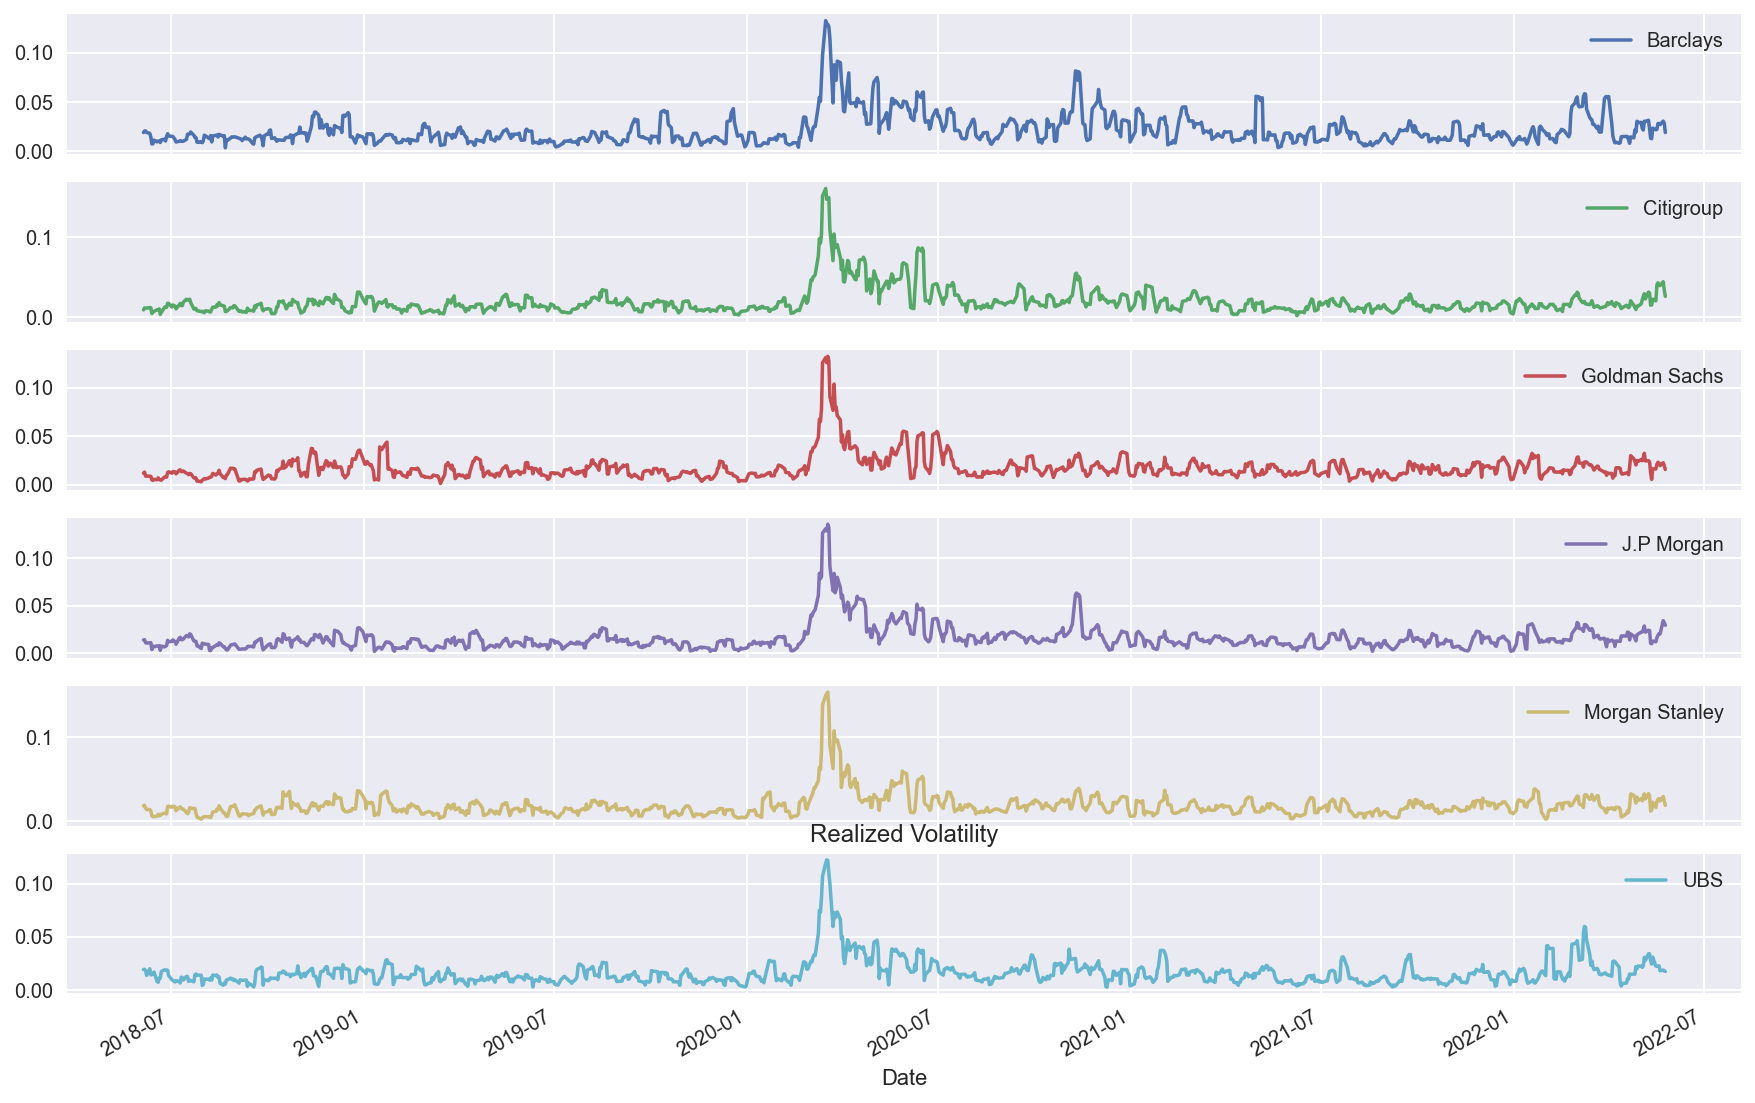

In [12]:
realized_vol = returns_df.rolling(5).std()
realized_vol.plot(figsize = (15, 10), subplots = True)
plt.title('Realized Volatility');

The plot shows the realized volatility of investment bank's over the period of 2018–2022. The most striking observation is the spikes around the COVID-19 pandemic.

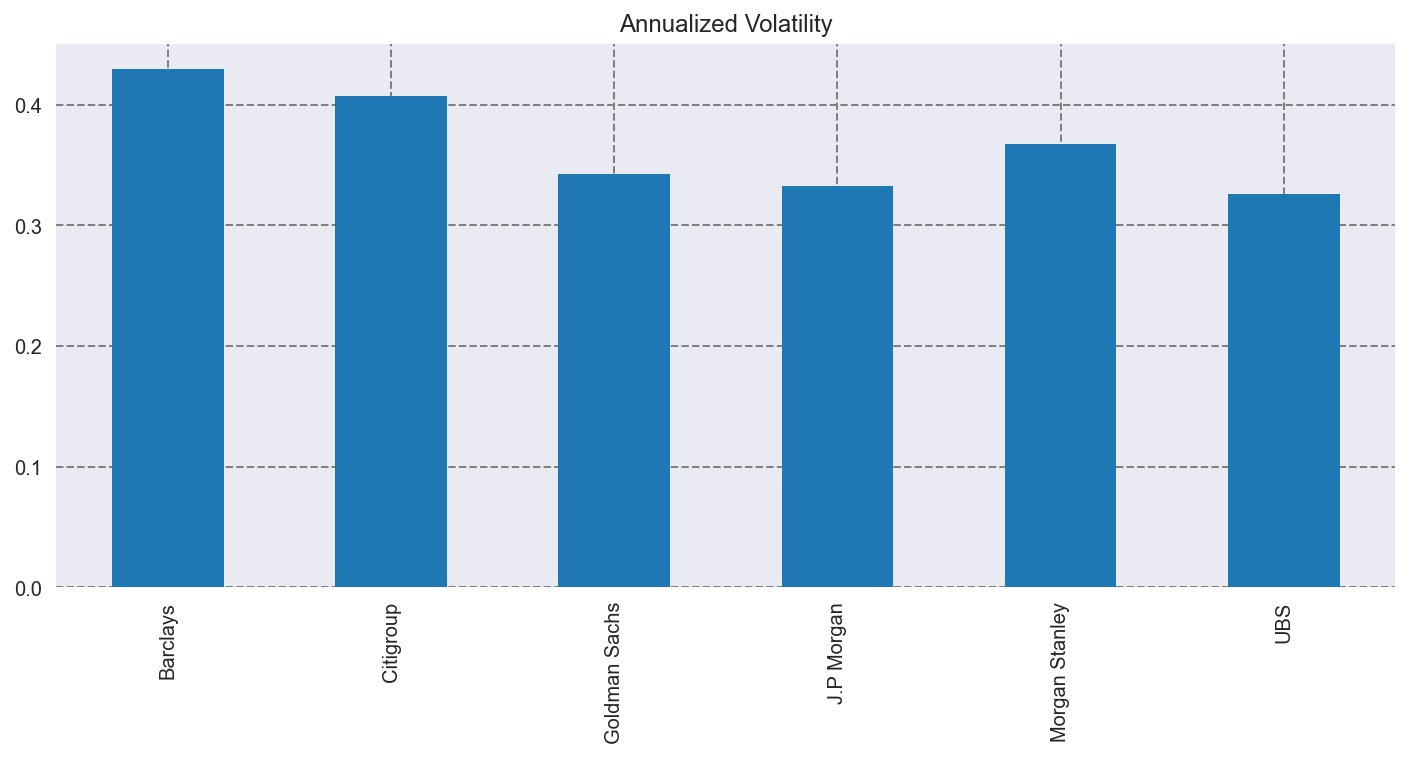

In [13]:
daily_volatility = returns_df.std()
annualized_volatility = daily_volatility*np.sqrt(252)
annualized_volatility.plot(kind = 'bar', colormap = 'tab20', figsize = (12,5))
plt.title('Annualized Volatility')
plt.grid(linestyle = '--', c = 'grey');

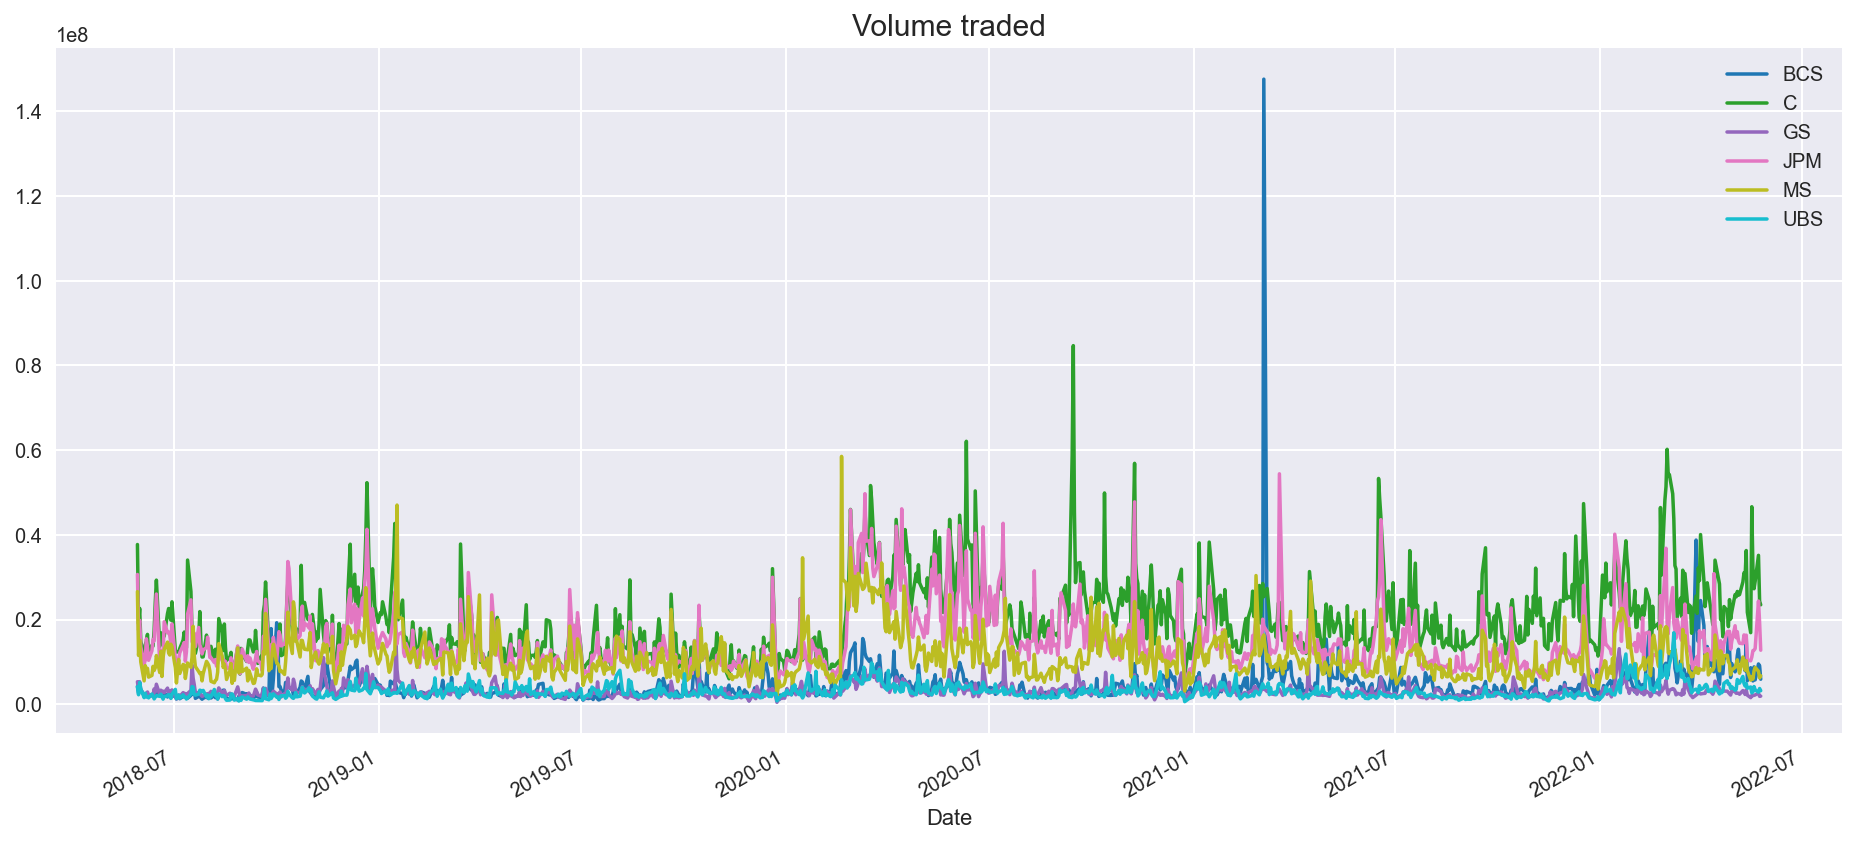

In [14]:
stock_volumes = stock_data['Volume'].copy()
stock_volumes.plot(figsize = (16,7), colormap = 'tab10')
plt.title('Volume traded', fontdict={'fontsize':15});

#### Market Capitalisation

In [15]:
stocks_close_price = stock_data['Close'].copy()
tickers =stocks_close_price.columns

def num_shares_outstanding(*tikers):
    data = {}
    for x in tickers:
        yahoo_financials = YahooFinancials(x)
        value = yahoo_financials.get_num_shares_outstanding()
        data[x] = int(value)
        num_shares_outstanding = pd.DataFrame(data, index = ['Shares Outstanding']).T
    return num_shares_outstanding 


shares_outstanding = num_shares_outstanding(tickers)
shares_outstanding

Shares Outstanding
BCS          4190500362
C            1941919973
GS            343447011
JPM          2937100087
MS           1749280010
UBS          3349140132

In [16]:
stocks_close_price = stock_data['Close'].copy()
df = pd.DataFrame(index = stocks_close_price.columns)

market_cap = {}
for i in range(len(stocks_close_price.columns)):
    value = stocks_close_price.iloc[-1, i] * shares_outstanding.iloc[i,0]
    market_cap[shares_outstanding.index[i]] = int(value)
    
    
market_cap = pd.DataFrame(market_cap, index = ['Market Capitalisation']).T
Market_capitalisation = shares_outstanding.join(market_cap).sort_values(by ='Market Capitalisation', ascending=True)
Market_capitalisation

Shares Outstanding  Market Capitalisation
BCS          4190500362            35284013367
UBS          3349140132            62093061113
C            1941919973           102339184058
GS            343447011           108151461667
MS           1749280010           143843301094
JPM          2937100087           373716608795

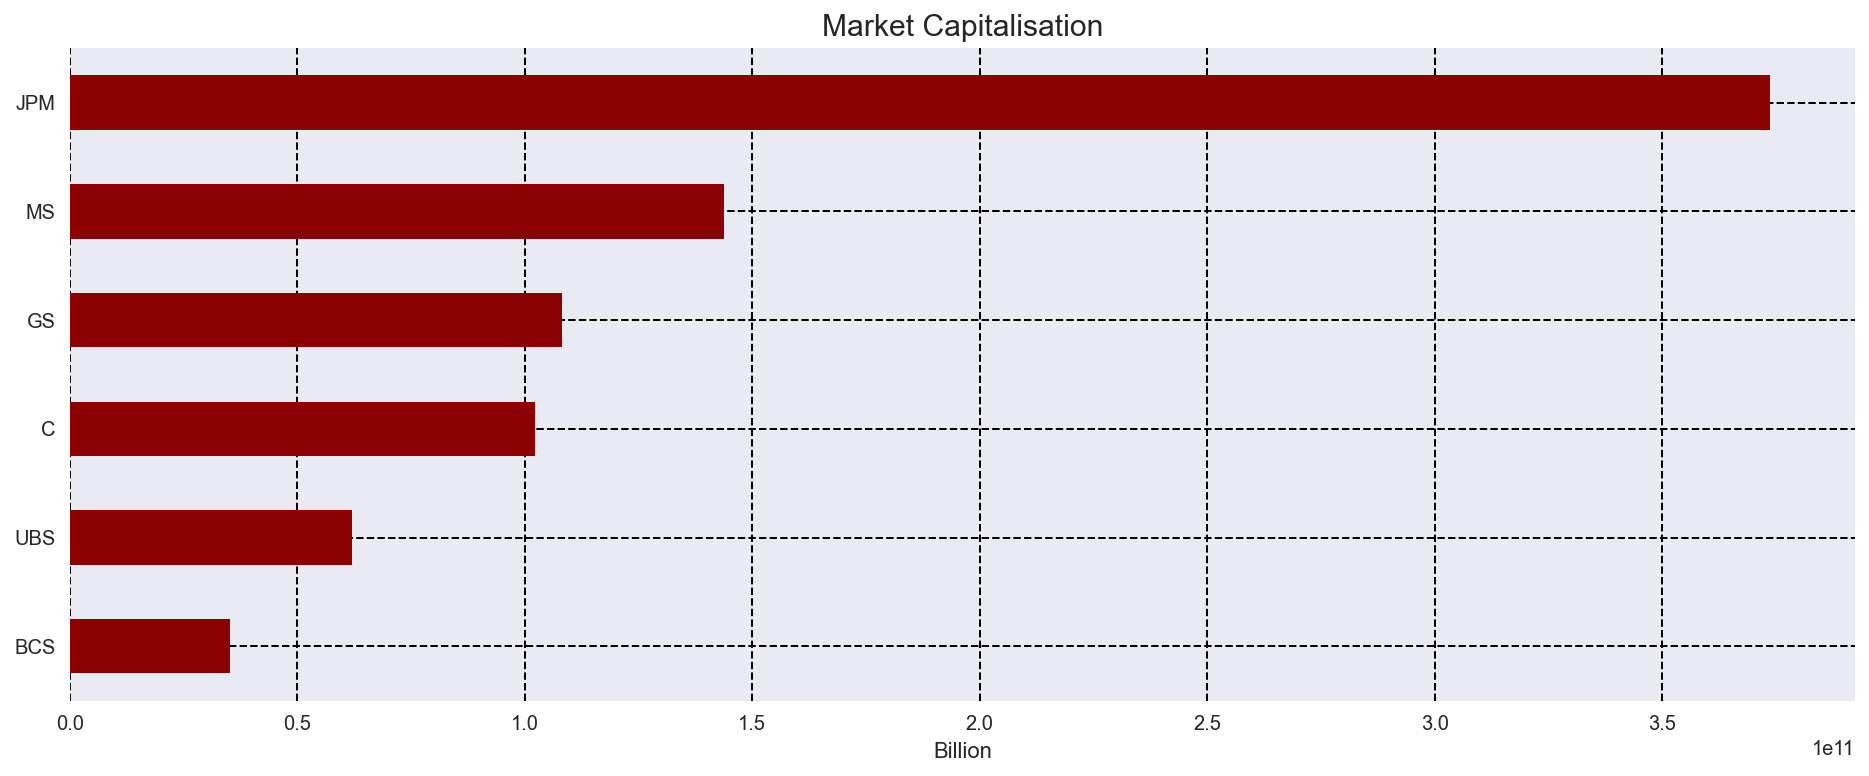

In [17]:
Market_capitalisation['Market Capitalisation'].plot(kind = 'barh', figsize = (16,6), color = 'Darkred')
plt.title('Market Capitalisation', fontdict={'fontsize': 15})
plt.xlabel('Billion')
plt.grid(linestyle = '--', c = 'k');

Let's see the relationship that exists between stocks and their respective price movements.

In [18]:
stocks_adj_close_price.corr()

Barclays  Citigroup  Goldman Sachs  J.P Morgan  \
Barclays        1.000000   0.816585       0.791768    0.829941   
Citigroup       0.816585   1.000000       0.534878    0.686232   
Goldman Sachs   0.791768   0.534878       1.000000    0.952509   
J.P Morgan      0.829941   0.686232       0.952509    1.000000   
Morgan Stanley  0.737217   0.434327       0.983590    0.925136   
UBS             0.785781   0.419305       0.904195    0.824588   

                Morgan Stanley       UBS  
Barclays              0.737217  0.785781  
Citigroup             0.434327  0.419305  
Goldman Sachs         0.983590  0.904195  
J.P Morgan            0.925136  0.824588  
Morgan Stanley        1.000000  0.924222  
UBS                   0.924222  1.000000

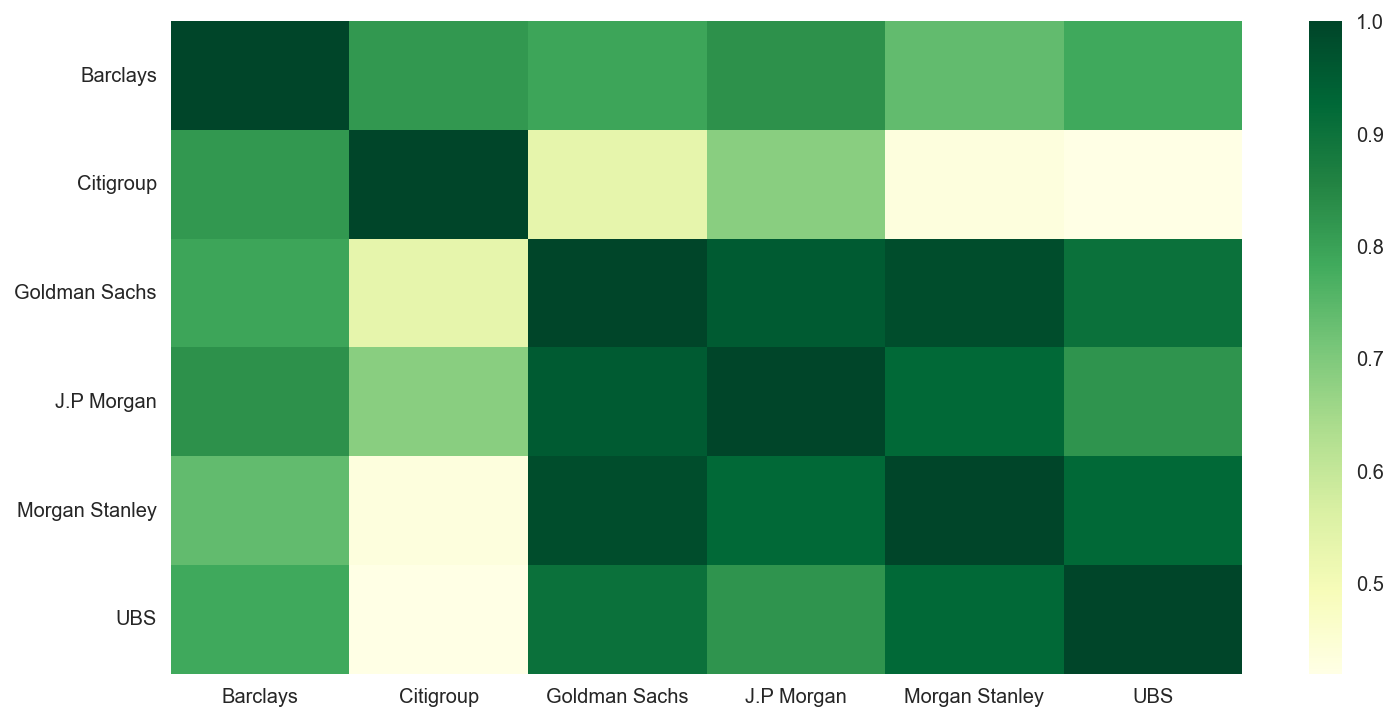

In [19]:
plt.figure(figsize = (12,6))
sns.heatmap(stocks_adj_close_price.corr(),cmap='YlGn');

# Part II
In this part, I will analyze J.P Morgan's stock price. Visualize raw data, rolling means, standard deviation, and log return and build a candlestick chart with volume traded. I perform exponential smoothing techniques like Simple Exponential Smoothing, Holt's Linear/Damped Smoothing, and Holt-Winter's Exponential Smoothing to predict future stock prices. I also forecast future adjusted stock prices using Moving Average, Autoregressive, and ARIMA models.

In [20]:
#J.P Morgan's Stock attributes
jpm_stock_data = stock_data.unstack()[:,'JPM'].to_frame().unstack().T.droplevel(0).copy()

In [21]:
jpm_stock_data.head()

Adj Close       Close  Dividends        High         Low  \
Date                                                                   
2018-05-29  94.235947  105.930000        0.0  109.199997  104.959999   
2018-05-30  96.388786  108.349998        0.0  108.599998  106.650002   
2018-05-31  95.196724  107.010002        0.0  108.190002  106.419998   
2018-06-01  96.433258  108.400002        0.0  108.940002  107.800003   
2018-06-04  96.477753  108.449997        0.0  109.260002  108.269997   

                  Open  Stock Splits      Volume  
Date                                              
2018-05-29  109.180000           0.0  30643800.0  
2018-05-30  107.639999           0.0  17490800.0  
2018-05-31  107.949997           0.0  19808200.0  
2018-06-01  108.339996           0.0  13594200.0  
2018-06-04  108.989998           0.0   9415400.0

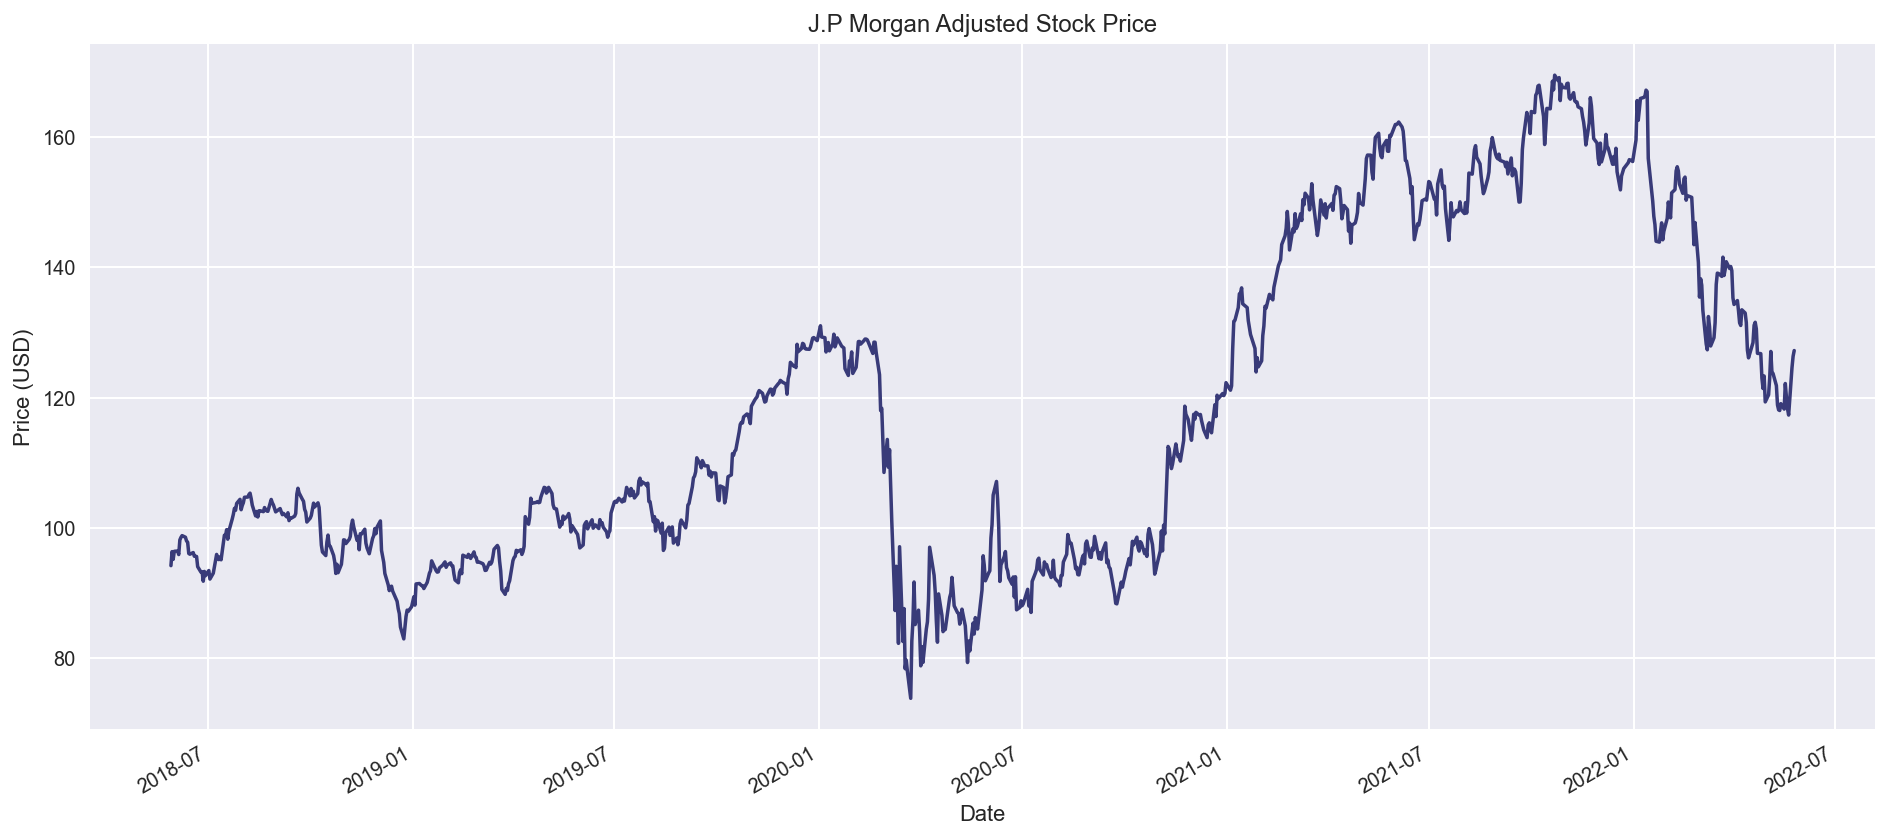

In [22]:
jpm_stock_data['Adj Close'].plot(figsize = (16,7), title = 'J.P Morgan Adjusted Stock Price', colormap = 'tab20b')
plt.ylabel('Price (USD)');

In [23]:
#summary statistics
jpm_stock_data.describe().round(2)

Adj Close    Close  Dividends     High      Low     Open  Stock Splits  \
count    1007.00  1007.00    1007.00  1007.00  1007.00  1007.00        1007.0   
mean      118.04   124.34       0.01   125.64   123.10   124.37           0.0   
std        25.30    23.32       0.11    23.38    23.27    23.33           0.0   
min        73.88    79.03       0.00    83.75    76.91    81.56           0.0   
25%        96.39   105.19       0.00   106.04   104.33   105.12           0.0   
50%       107.65   116.71       0.00   117.53   115.41   116.75           0.0   
75%       144.08   146.79       0.00   148.81   144.47   145.75           0.0   
max       169.50   171.78       1.00   172.96   170.54   172.71           0.0   

            Volume  
count      1007.00  
mean   14887892.35  
std     7022024.81  
min     3324300.00  
25%    10254000.00  
50%    13022200.00  
75%    17080000.00  
max    54418800.00

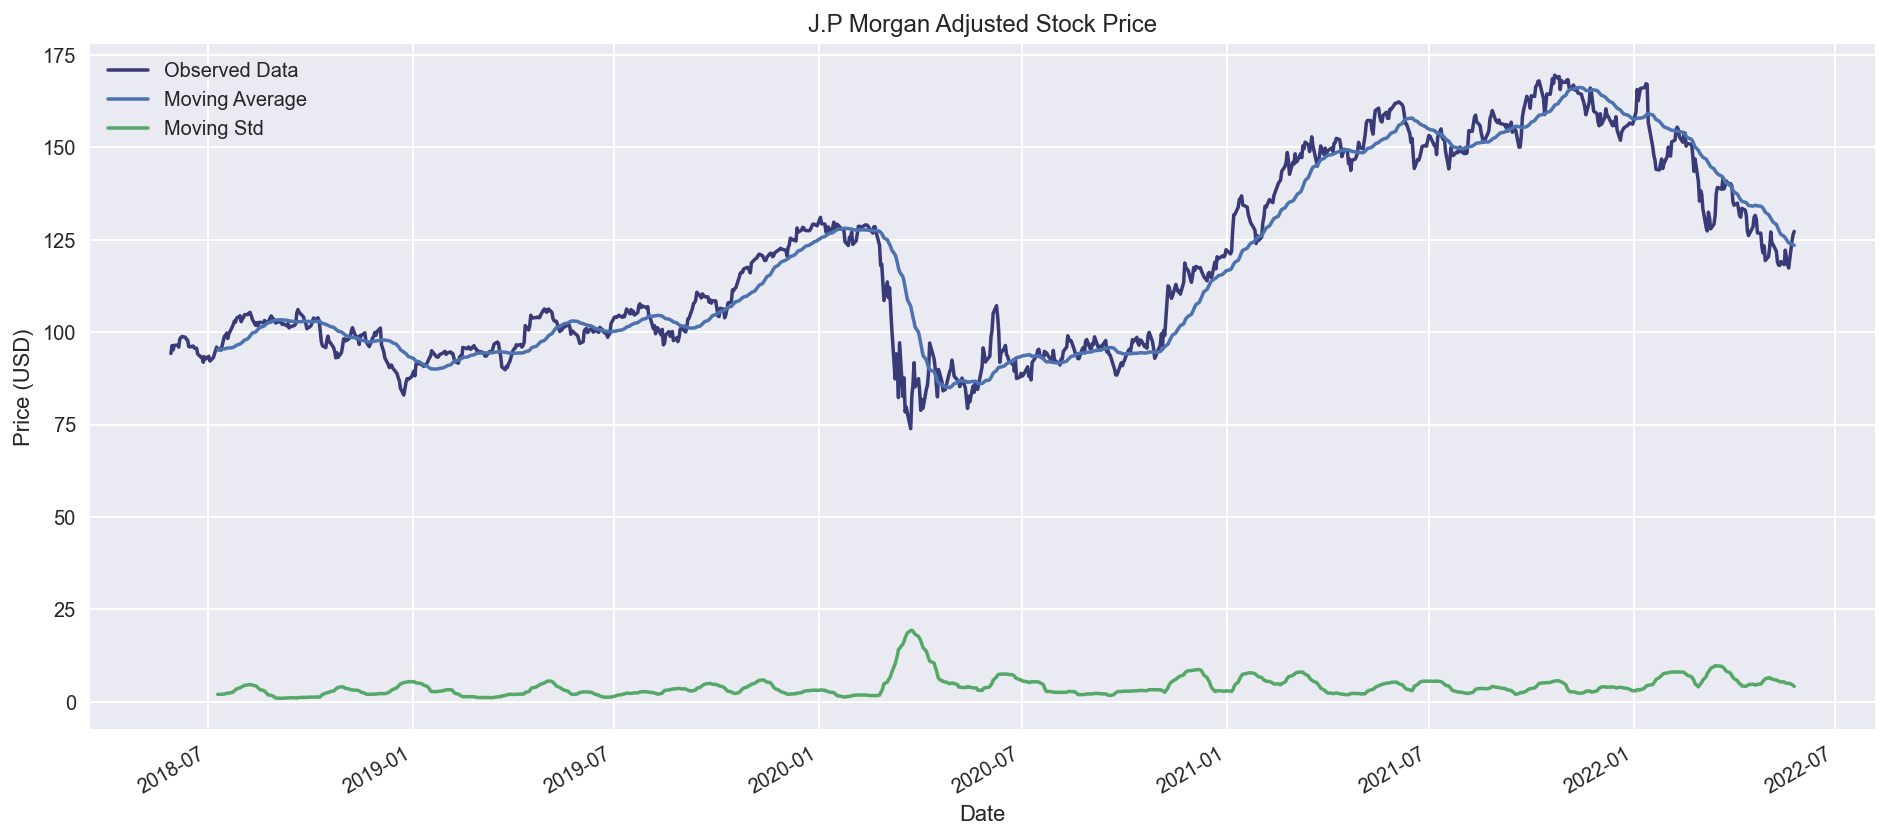

In [24]:
jpm_stock_data['ma_30'] = jpm_stock_data['Adj Close'].rolling(30).mean()
jpm_stock_data['msd_30'] = jpm_stock_data['Adj Close'].rolling(30).std()

jpm_stock_data['Adj Close'].plot(figsize = (16,7),label = 'Observed Data', legend = True, title = 'J.P Morgan Adjusted Stock Price', colormap = 'tab20b')
jpm_stock_data['ma_30'].plot(label = 'Moving Average', legend = True)
jpm_stock_data['msd_30'].plot(label = 'Moving Std', legend = True)
plt.ylabel('Price (USD)');

In [25]:
jpm_stock_data['Log returns'] = np.log(jpm_stock_data['Adj Close'])- np.log(jpm_stock_data['Adj Close'].shift(1))
jpm_stock_data['Simple returns'] = jpm_stock_data['Adj Close'].pct_change()

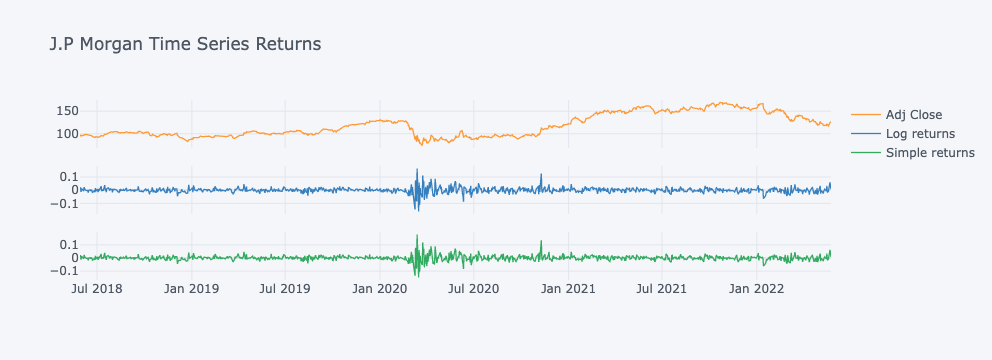

In [26]:
jpm_stock_data[['Adj Close', 'Log returns', 'Simple returns']].iplot(
    subplots=True, shape=(3,1),
    shared_xaxes=True,
    title='J.P Morgan Time Series Returns')

Skew: -0.06
Mean: 0.0003
Median: 0.0
Standard deviation of returns
0.021


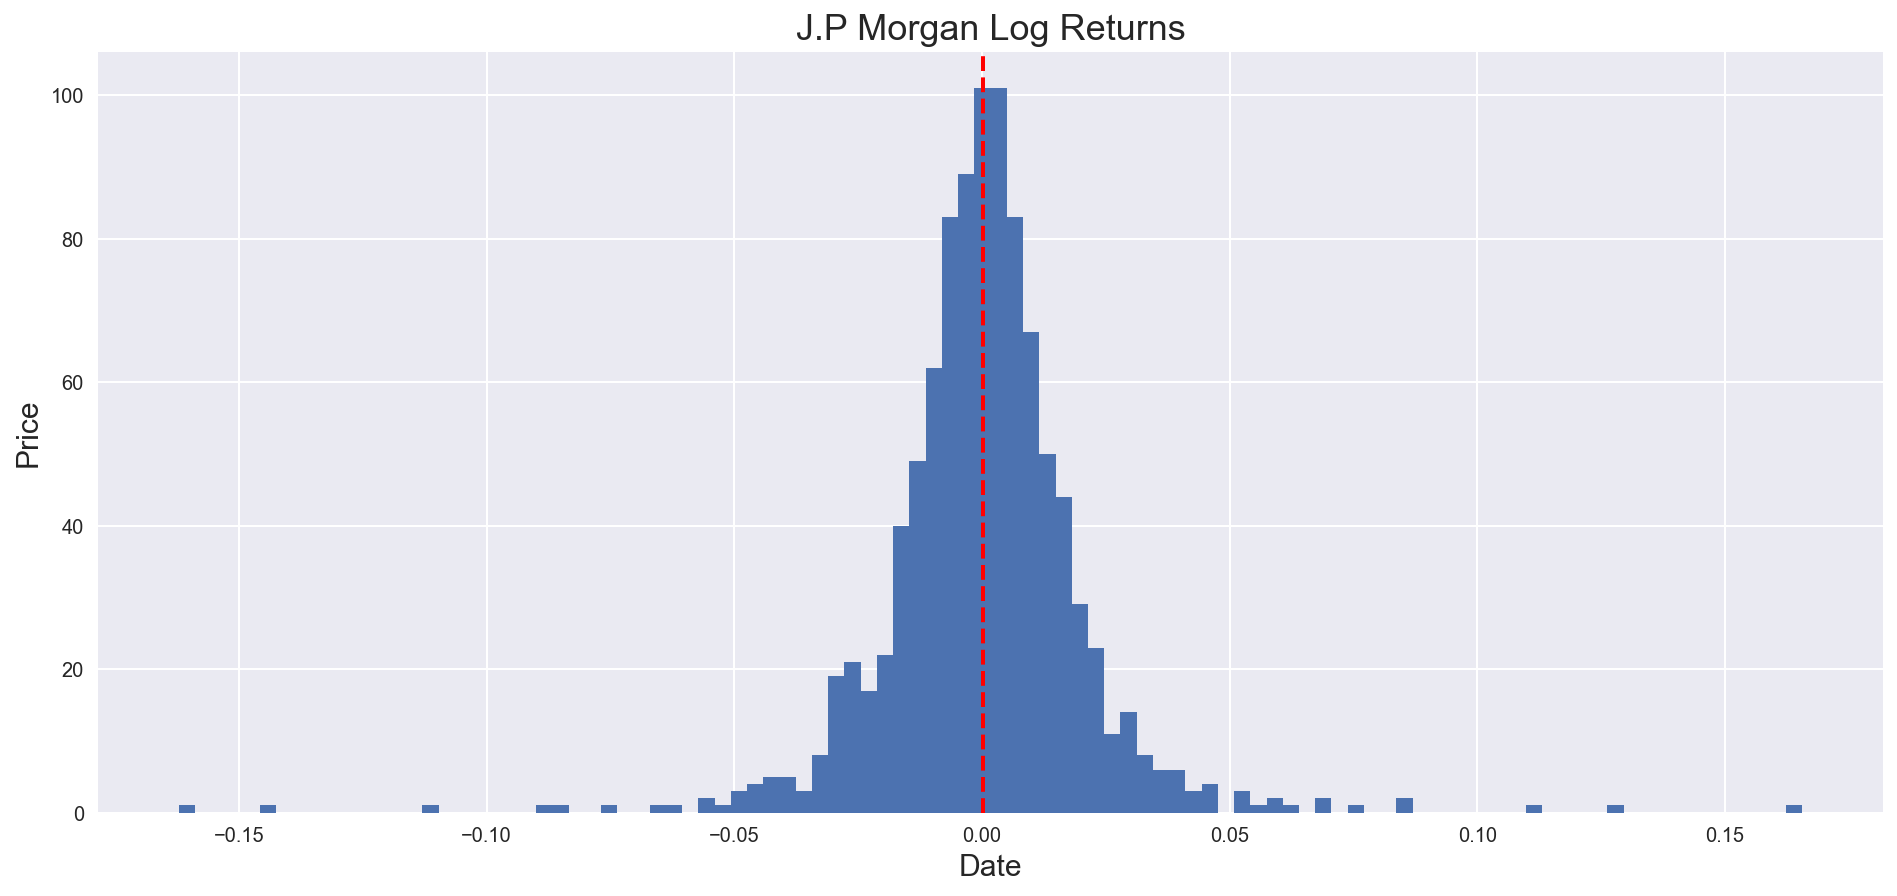

In [27]:
# Histogram of Daily Returns
print('Skew:', round(stats.skew(jpm_stock_data['Log returns'].dropna()),3))
print('Mean:', round(np.mean(jpm_stock_data['Log returns']), 4))
print('Median:', round(np.median(jpm_stock_data['Log returns'].dropna()),3))
print('Standard deviation of returns')
print(round(jpm_stock_data['Log returns'].std(),3))

plt.figure(figsize = (16,7))
plt.hist(jpm_stock_data['Log returns'], bins=100, label='Daily Returns data')
plt.axvline(jpm_stock_data['Log returns'].mean(), color='r', linestyle='dashed', linewidth=2) # Shows the average line
plt.title('J.P Morgan Log Returns',fontsize=18)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Price', fontsize = 15 )
plt.show()

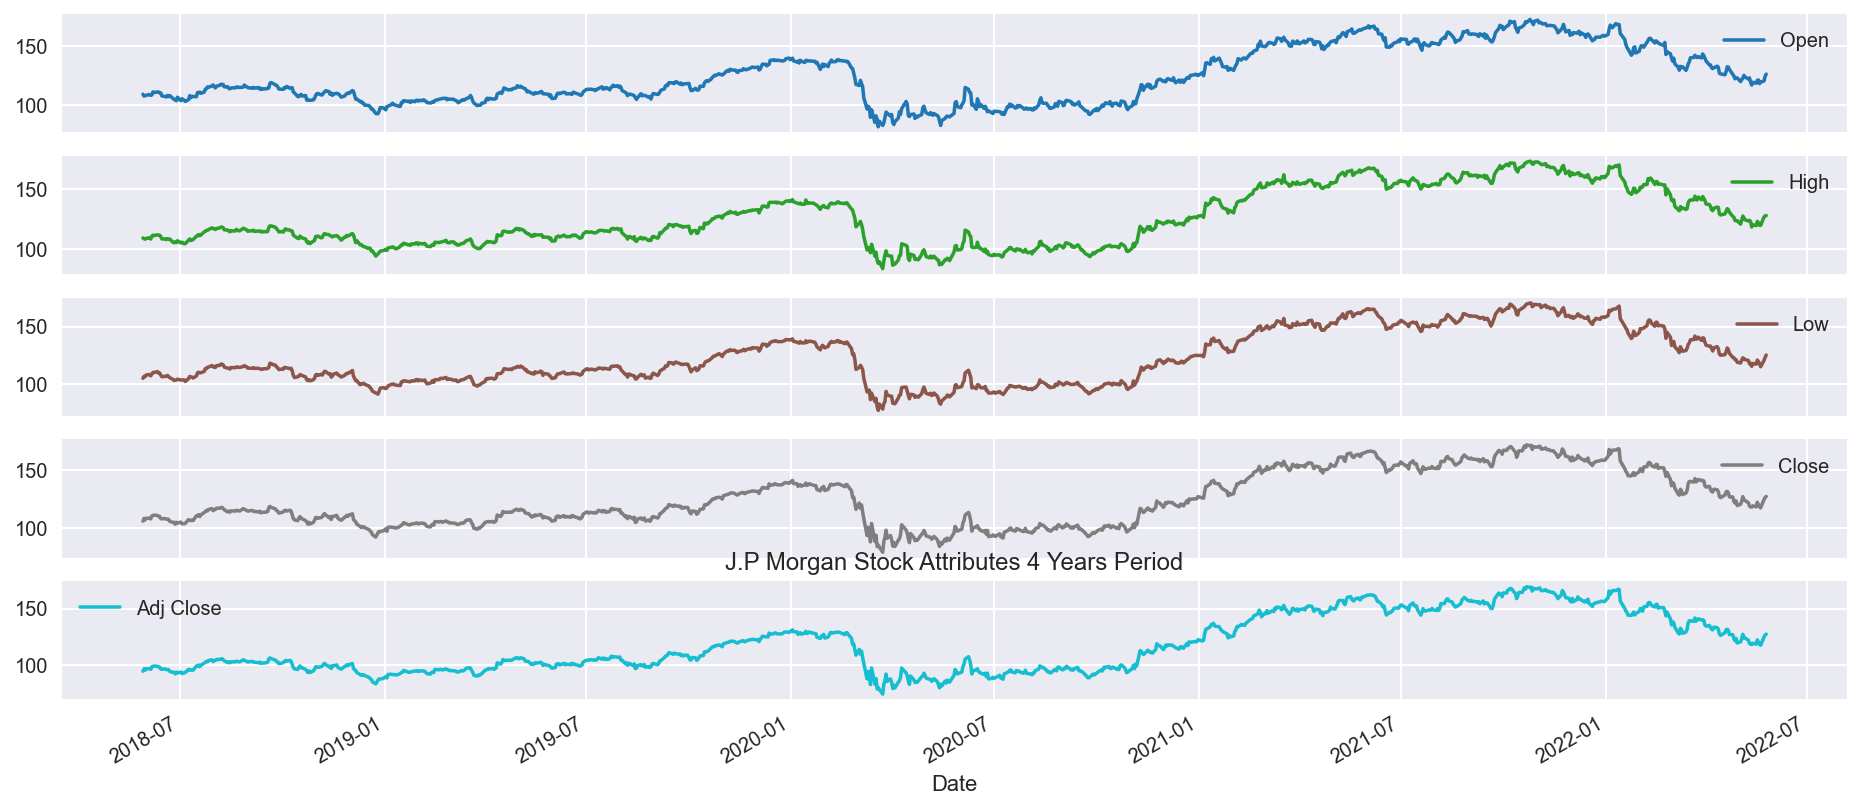

In [28]:
jpm_stock_data[['Open', 'High', 'Low', 'Close', 'Adj Close']].plot(figsize = (16,7), subplots = True, colormap = 'tab10');
plt.title('J.P Morgan Stock Attributes 4 Years Period')
plt.show()

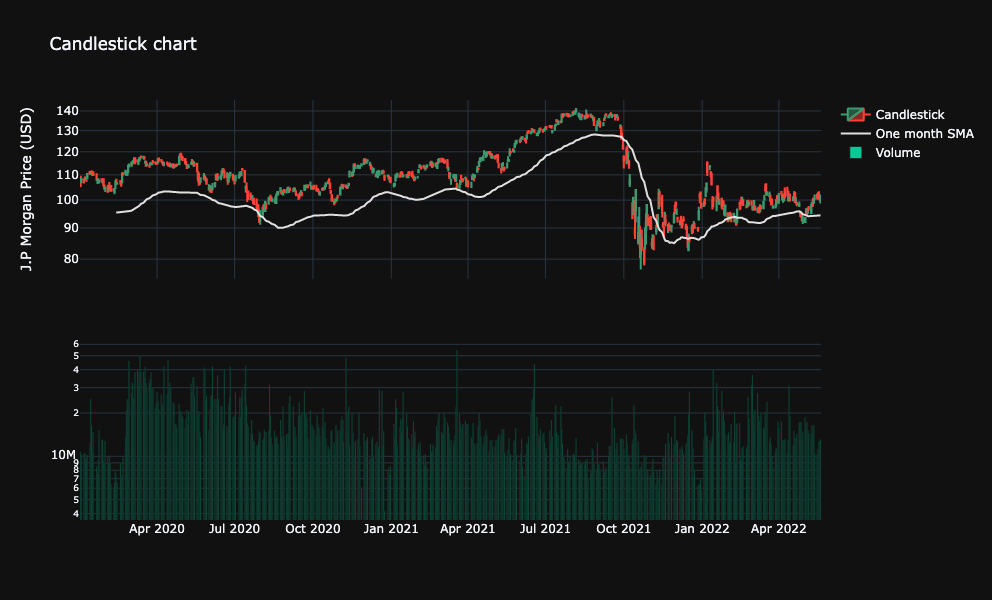

In [29]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)
fig.add_trace(go.Candlestick(x = jpm_stock_data.loc['2020-01-01':'2022-05-20'].index,
                                      open = jpm_stock_data['Open'],
                                       high=jpm_stock_data['High'],
                                       low=jpm_stock_data['Low'],
                                       close=jpm_stock_data['Close'],
                                       name = 'Candlestick'),row=1, col=1
             )
fig.add_trace(
    go.Scatter(
        x = jpm_stock_data.loc['2020-01-01':'2022-05-20'].index, 
        y = jpm_stock_data['ma_30'],
        line = dict(color = '#e0e0e0'), name = 'One month SMA'
    ))



fig.add_trace(
    go.Bar(x = jpm_stock_data.loc['2020-01-01':'2022-05-20'].index,
           y=jpm_stock_data.loc['2020-01-01':'2022-05-20','Volume'], name = 'Volume'),
    secondary_y=False, row=2, col=1)


fig.update_layout(
    title_text = 'Candlestick chart',
    xaxis_rangeslider_visible = False, template = 'plotly_dark', 
                  yaxis_title = 'J.P Morgan Price (USD)', width=1000, height=600,)

fig.update_yaxes(type = 'log')
fig.show()

After taking the first difference, it is quite obvious that the series fluctuates around its mean and it is referred to as weakly stationary.

## Exponencial Smoothing
Smoothing is a statistical method we can use to create an approximation function to remove irregularities in data and attempt to capture significant patterns.
The smoothing technique is a family of time-series forecasting algorithms, which utilizes the weighted averages of a previous observation to predict or forecast a new value. The main idea of this technique is to overweight recent values in a time series.

I will perform univariate analysis on the adjusted close price of the stock and forecasting using Simple Exponential Smoothing, Holt's Exponential Smoothing, and Holt - Winter Exponential Smoothing.

In [30]:
#to perform exponential smoothing I am going to take weekly data
jpm_week_data = jpm_stock_data['Adj Close'].copy().resample('W').mean().to_frame()

train_data_es= jpm_week_data.iloc[:int(jpm_week_data.shape[0]*0.90)]
test_data_es= jpm_week_data.iloc[int(jpm_week_data.shape[0]*0.90):]
train_data_es.rename(columns = {'Adj Close': 'Train data'}, inplace = True)
test_data_es.rename(columns = {'Adj Close': 'Test data'}, inplace = True)
print('Total:', jpm_week_data.shape[0])
print('Train data size:', train_data_es.shape[0])
print('Test data size:', test_data_es.shape[0])

Total: 209
Train data size: 188
Test data size: 21


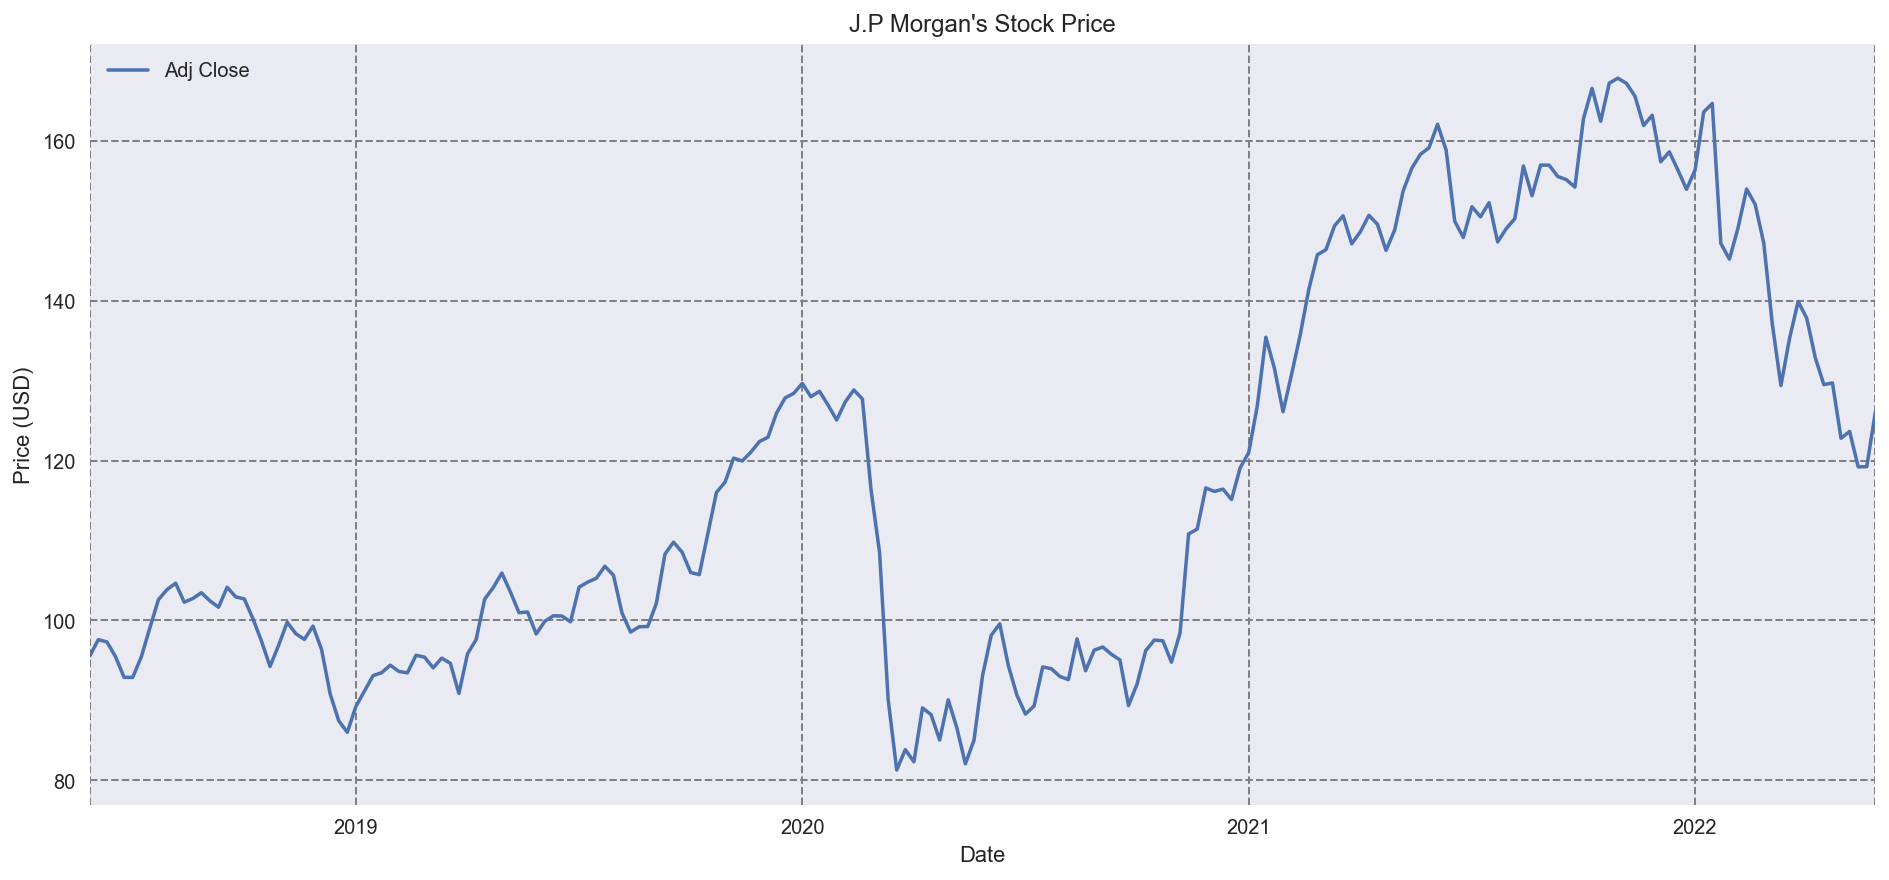

In [31]:
jpm_week_data.plot(title="J.P Morgan's Stock Price", figsize = (16,7));
plt.ylabel('Price (USD)')
plt.legend(loc = 'upper left')
plt.grid(linestyle = '--', c = 'grey');

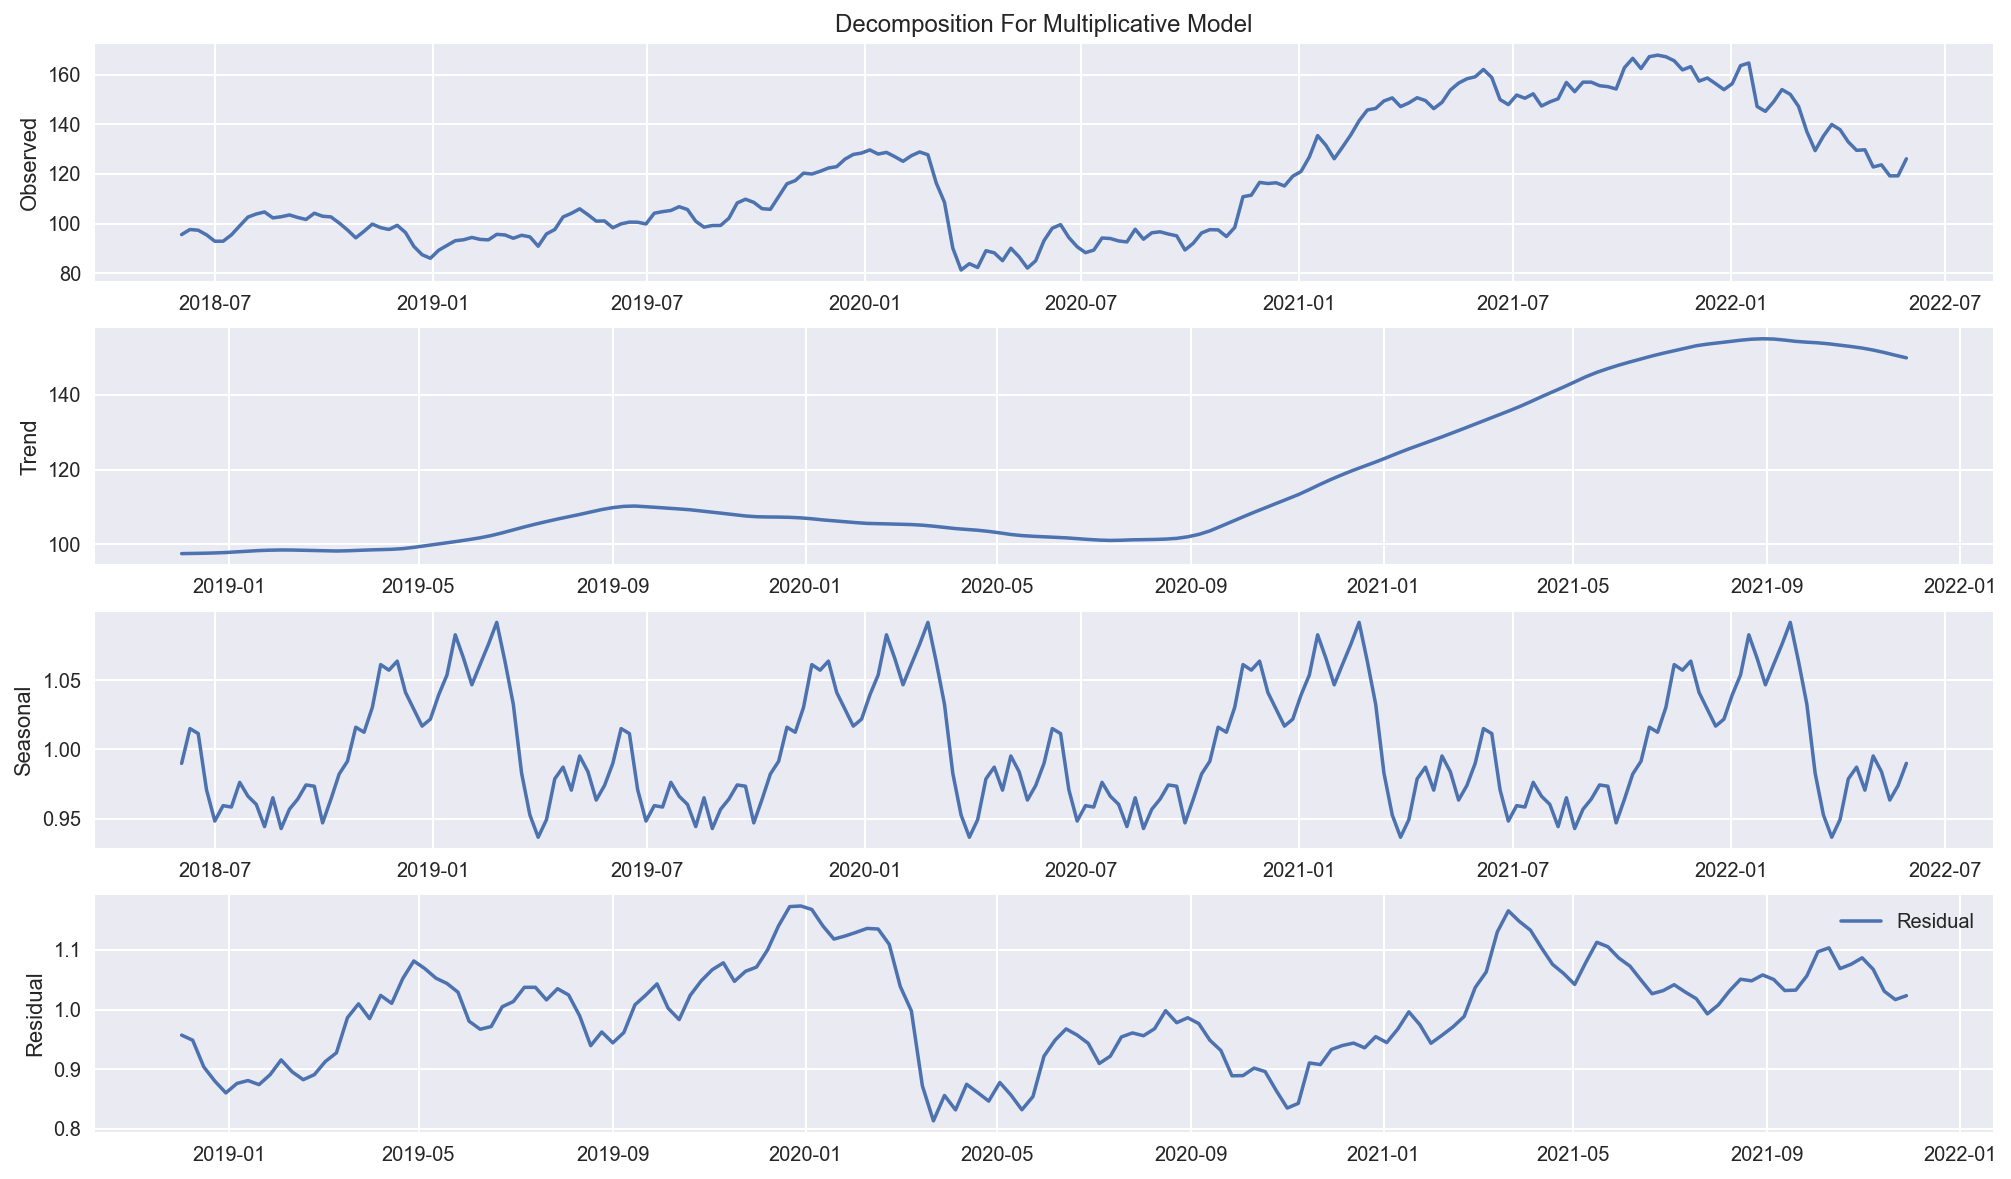

In [32]:
decomposed_weekly_data = sm.tsa.seasonal_decompose(jpm_week_data, model = 'multiplicative')

fig, ax = plt.subplots(4,1,figsize =(17,10))
ax[0].plot(decomposed_weekly_data.observed)
ax[0].set_ylabel('Observed')
ax[0].set_title('Decomposition For Multiplicative Model')

ax[1].plot(decomposed_weekly_data.trend)
ax[1].set_ylabel('Trend')

ax[2].plot(decomposed_weekly_data.seasonal, label = 'Seasonal')
ax[2].set_ylabel('Seasonal')

ax[3].plot(decomposed_weekly_data.resid, label = 'Residual')
ax[3].set_ylabel('Residual')

plt.legend()
plt.show()

I will create a function that has all the required evaluation metrics, which will give us the results in one go. This function helps us understand how far off our forecasts are against the actuals.

In [33]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
        #Evaluation metric results
        MSE= metrics.mean_squared_error(y_true, y_pred)
        MAE = metrics.mean_absolute_error(y_true, y_pred)
        RMSE = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
        MAPE = mean_absolute_percentage_error(y_true, y_pred)
        R2 = metrics.r2_score(y_true, y_pred)

In [34]:
resu = []
temp_df = pd.DataFrame()
for i in [0, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90,1]:
    
    fit_v = SimpleExpSmoothing(np.asarray(train_data_es)).fit(i)
    fcst_pred_v= fit_v.forecast(len(test_data_es))
    
    timeseries_evaluation_metrics_func(test_data_es,fcst_pred_v)
    rmse = np.sqrt(mean_squared_error(test_data_es, fcst_pred_v))
    df3 = {'smoothing parameter':i, 'RMSE': rmse}
    temp_df = temp_df.append(df3, ignore_index=True)
temp_df.sort_values(by=['RMSE']).head(3)

smoothing parameter       RMSE
7                  0.7  22.001452
6                  0.6  22.031159
8                  0.8  22.059840

From the previous search, the least RMSE was achieved with smoothing_level equal to 1.0. But we need to be aware since choosing smoothing parameter with least RMSE can lead us to overfitting, this is why I will apply  	$\alpha$ = 0.2, since it is used more frequently.

In [35]:
#when alpha is high the dacay is faster and we give less weight to past data and viceversa
ses_1 = SimpleExpSmoothing(train_data_es).fit(smoothing_level=0.2)
ses_1_forecast = ses_1.forecast(len(test_data_es))

#Here we allow statsmodels to automatically find an optimized value aplha
ses_3 = SimpleExpSmoothing(train_data_es).fit()
alpha = ses_3.model.params['smoothing_level']
ses_3_forecast = ses_3.forecast(len(test_data_es))

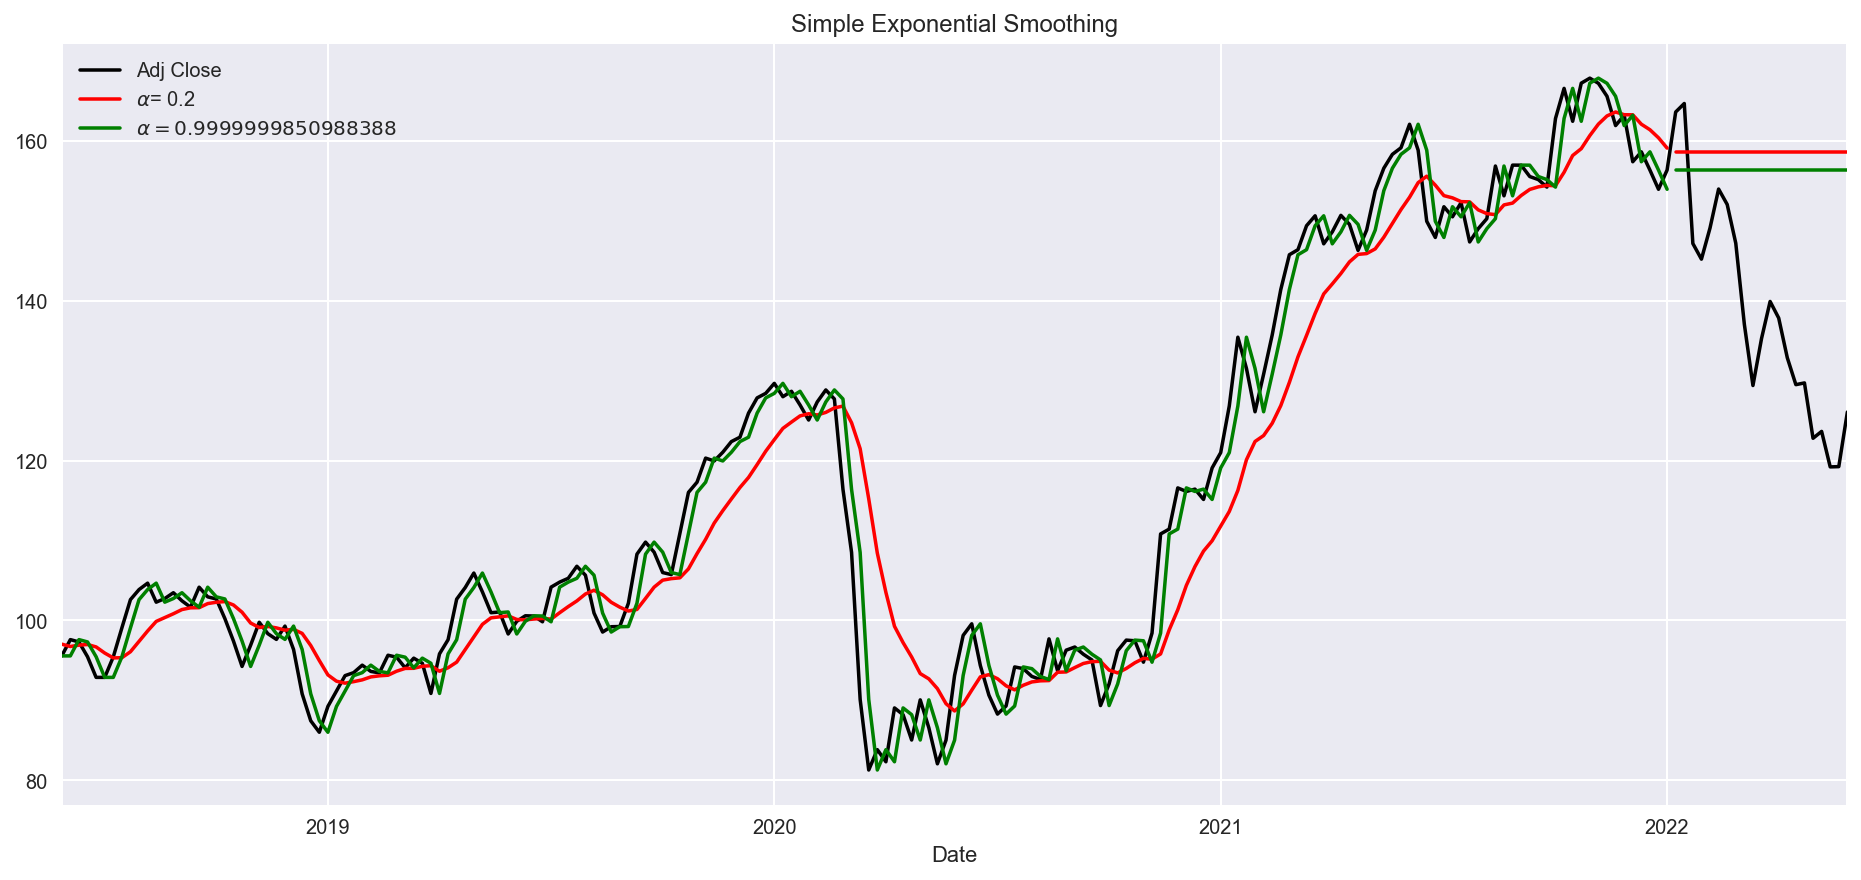

In [36]:
jpm_week_data.plot(color = 'k',
                    title = 'Simple Exponential Smoothing',
                    legend = True,
                    figsize = (16,7))
ses_1_forecast.plot(label = r'$\alpha$= 0.2', color ='r',legend = True)
ses_1.fittedvalues.plot(color ='r')

ses_3_forecast.plot(label = r'$\alpha ={} $'.format(alpha), 
                    color = 'green',legend = True)
ses_3.fittedvalues.plot(color = 'green')
plt.show()

We can see that the simple exponential smoothing is not performing well on the stock market data, since they have trends and seasonality. Our basic model will not be able to capture these details.

### Double Exponential Smoothing / Holt's Esponential Smoothing

Holt's exponential smoothing is an extension of Simple Exponencial Smoothing, and integrate trend term. The time series must have following features - Level, Trend, Noise (unpredictable), No Seasonality. In the model we can two updating equations:
* The Level updating equation with $\alpha$- smoothing parameter
* The Trend updating equation with $\beta$ - smoothing slope

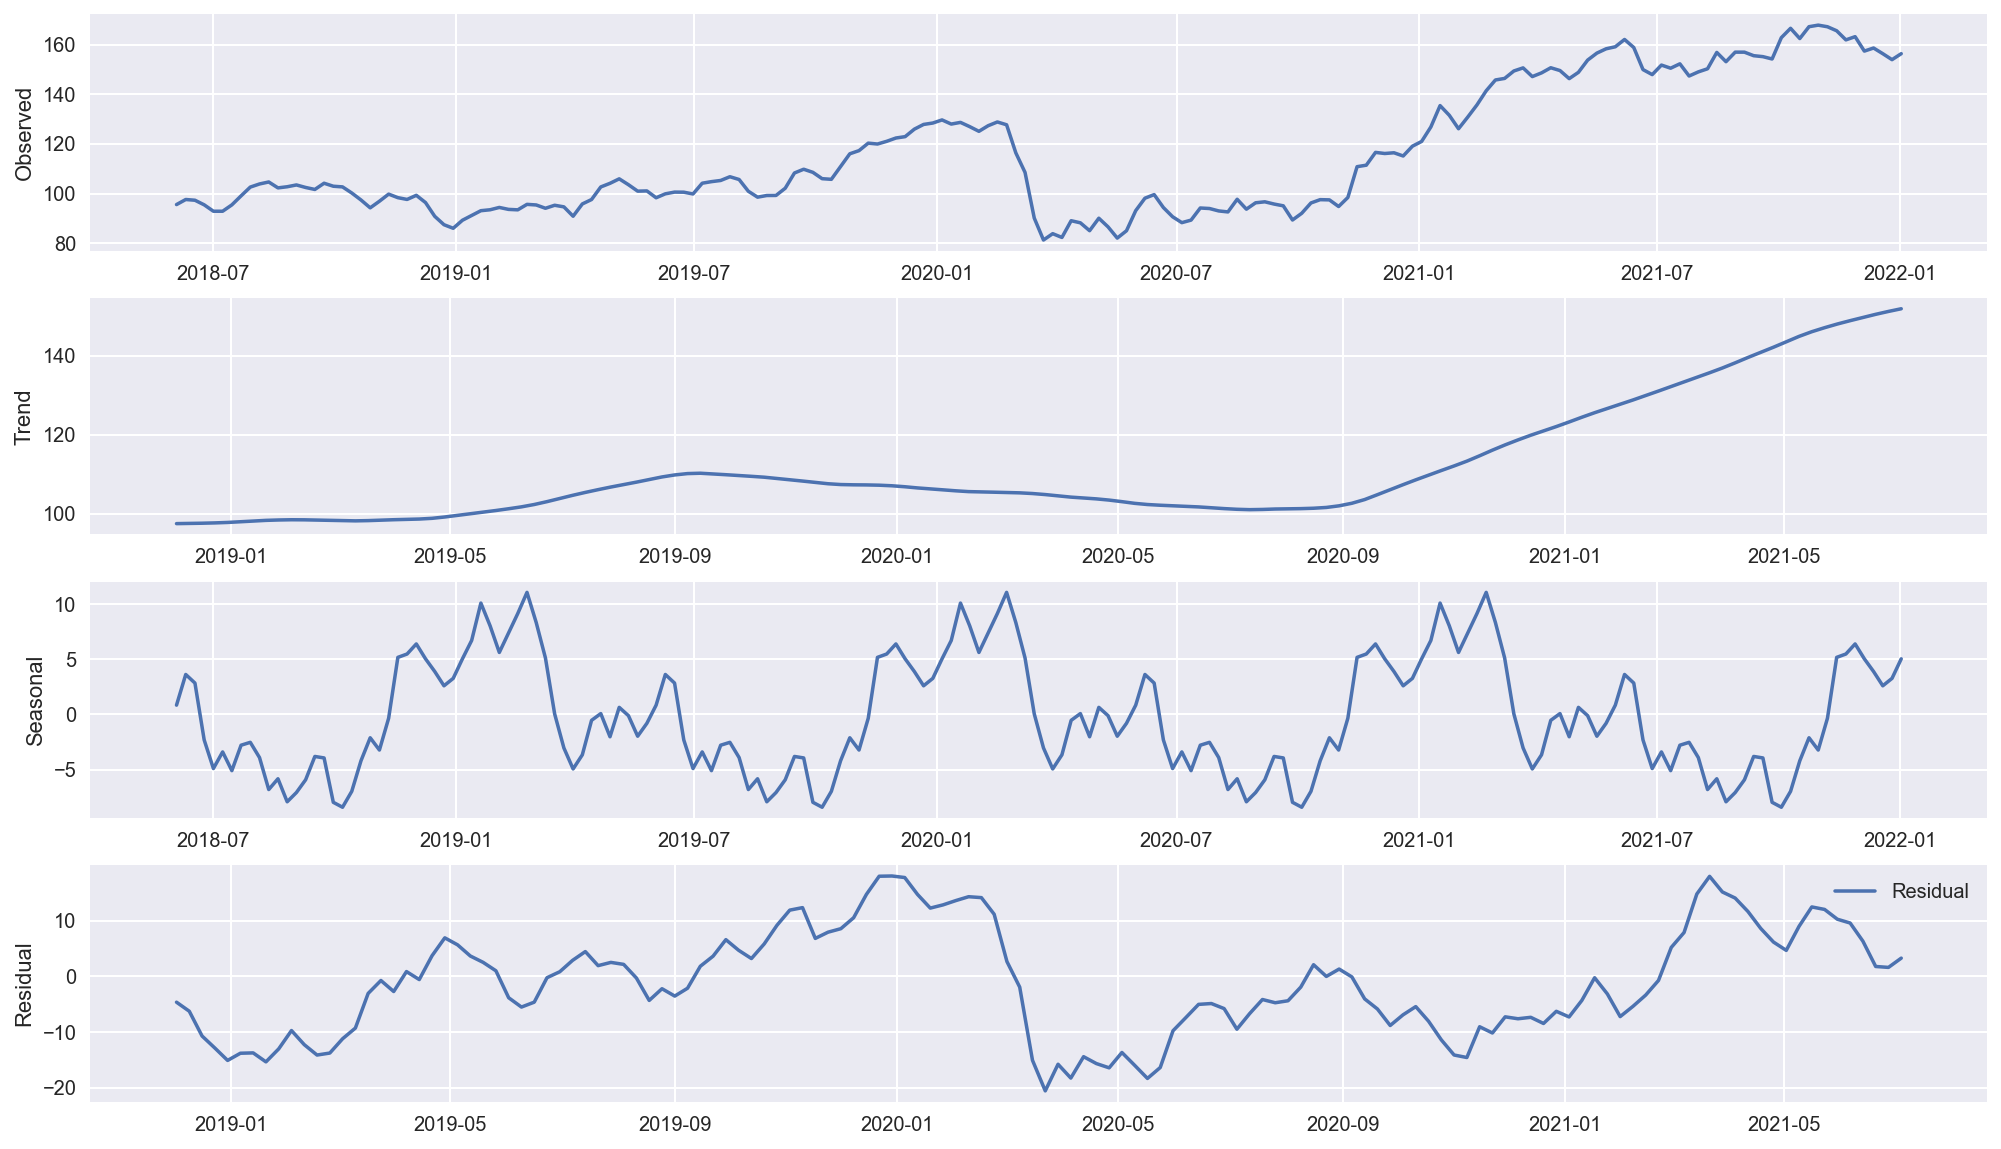

In [37]:
#decompose train data and plot it
decomposed_jpm_price = seasonal_decompose(train_data_es, period = 52)
fig, ax = plt.subplots(4,1,figsize =(17,10))
ax[0].plot(decomposed_jpm_price.observed)
ax[0].set_ylabel('Observed')
ax[1].plot(decomposed_jpm_price.trend)
ax[1].set_ylabel('Trend')
ax[2].plot(decomposed_jpm_price.seasonal, label = 'Seasonal')
ax[2].set_ylabel('Seasonal')
ax[3].plot(decomposed_jpm_price.resid, label = 'Residual')
ax[3].set_ylabel('Residual')
plt.legend()
plt.show()

We could observe that the data has a polynomial trend and additive seasonality. 

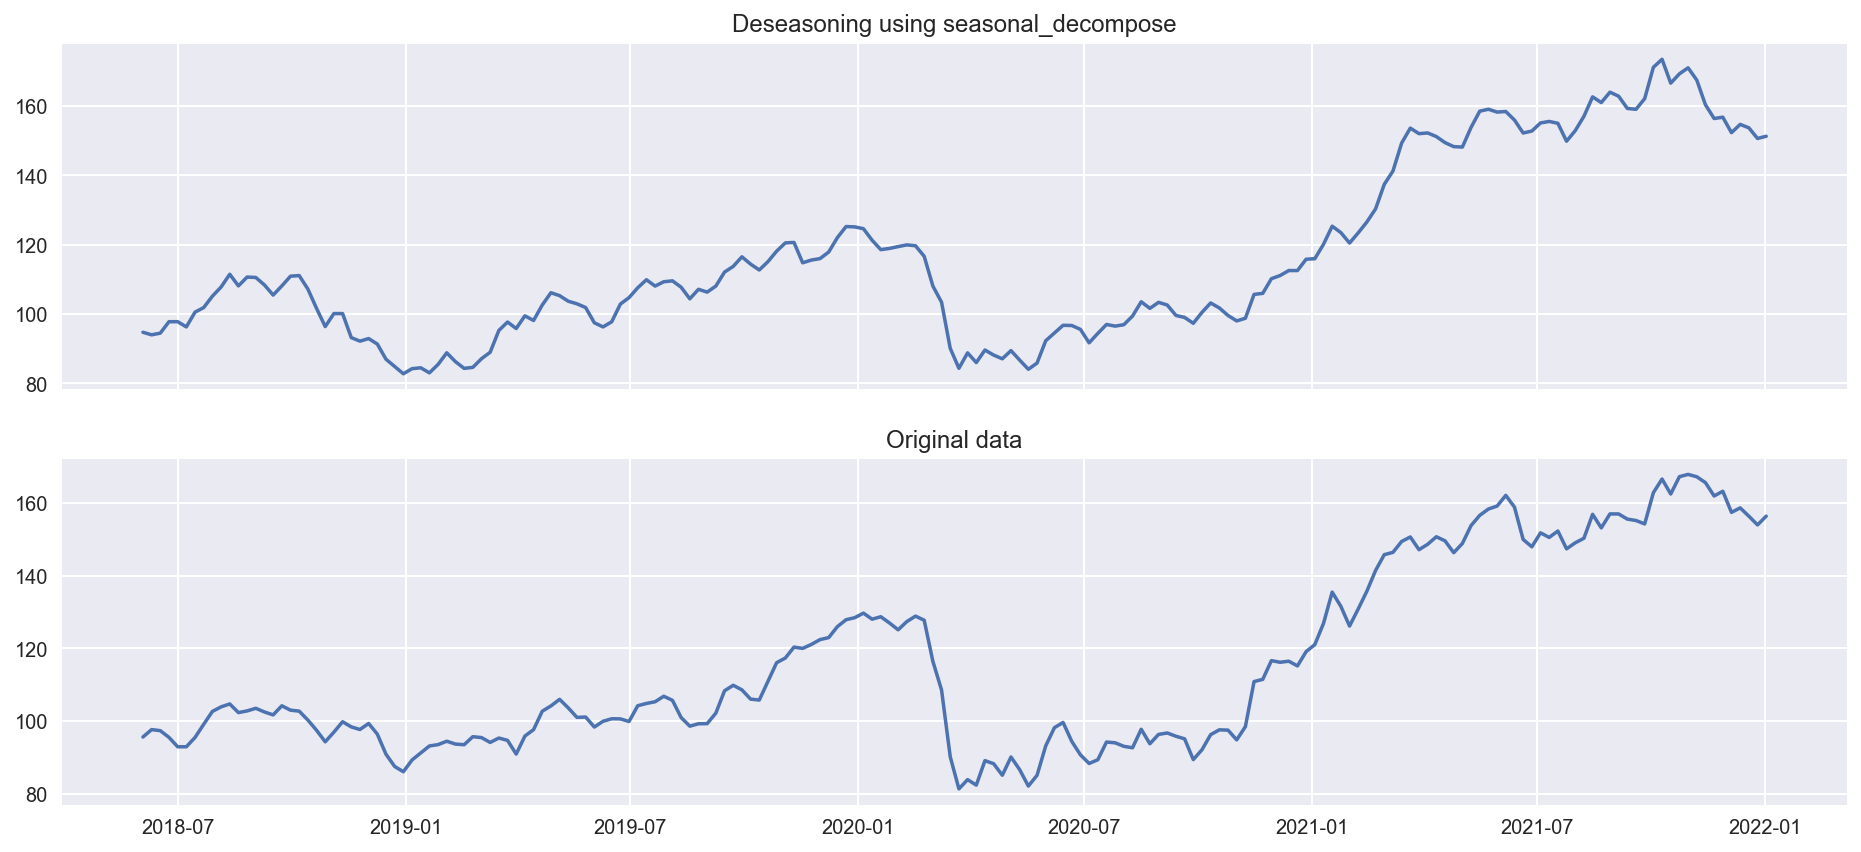

In [38]:
deseason_data = train_data_es['Train data'] - decomposed_jpm_price.seasonal
deseason_data.dropna(inplace = True)
#plot for comparison
fig, ax = plt.subplots(2,1, sharex = True, figsize = (16,7))
ax[0].plot(deseason_data)
ax[0].set_title('Deseasoning using seasonal_decompose')
ax[1].plot(train_data_es)
ax[1].set_title('Original data');

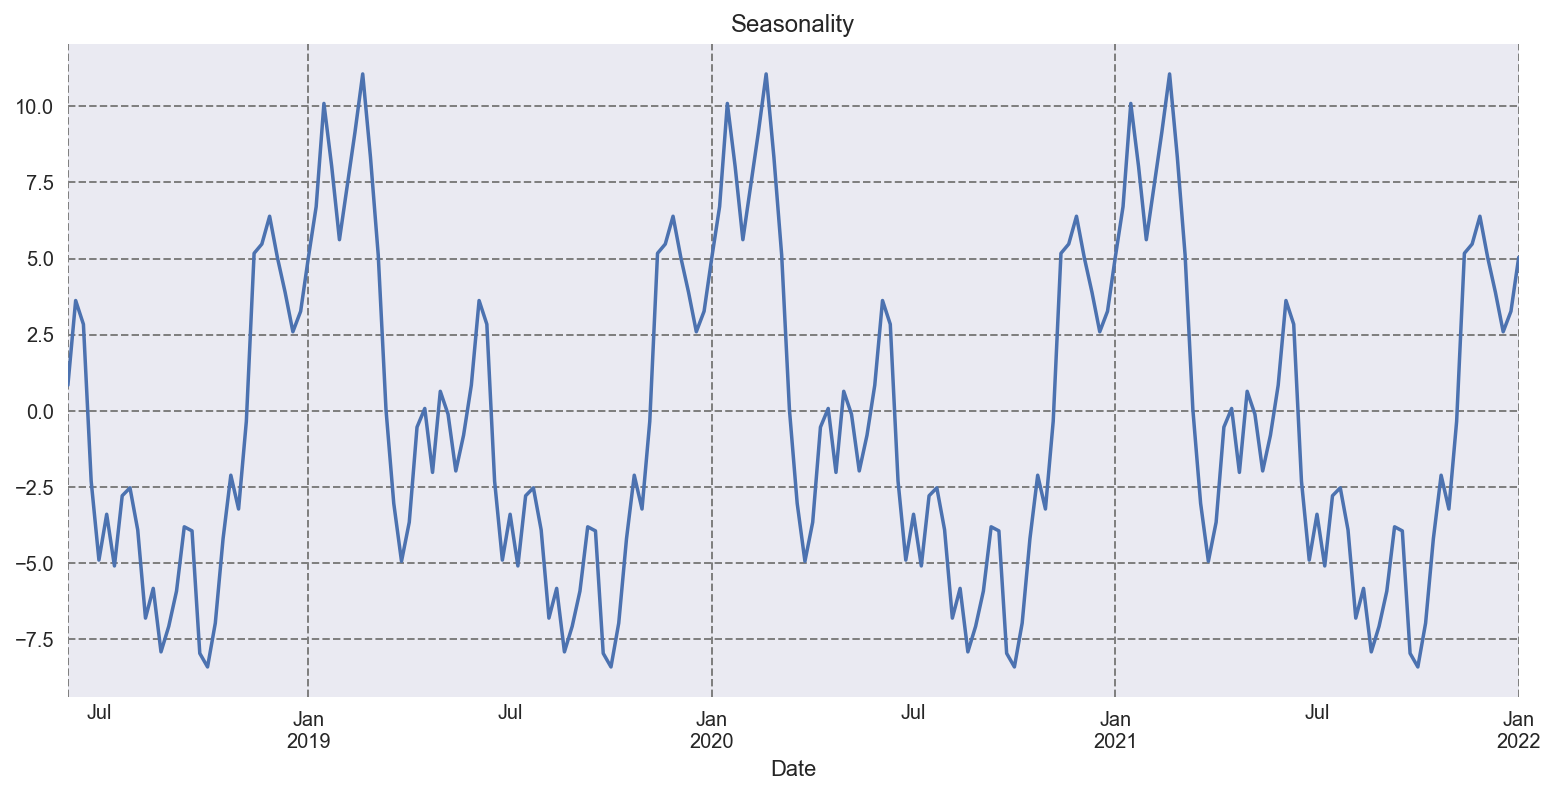

In [39]:
seasonality =decomposed_jpm_price.seasonal
seasonality.plot(title = 'Seasonality', figsize = (13,6))
plt.grid(linestyle = '--', c = 'grey');

In the seasonality graph, we can see the seasonality structure for every year, which is cyclic and repeatedly provides the same values.

In [40]:
model_1 = ExponentialSmoothing(deseason_data, trend= 'mul', seasonal = None).fit(smoothing_level = 0.2)
model_2 = ExponentialSmoothing(deseason_data, trend= 'mul', seasonal = None, damped = True).fit(smoothing_level = 0.2)
yhat_1 = model_1.forecast(len(test_data_es))
yhat_2 = model_2.forecast(len(test_data_es))

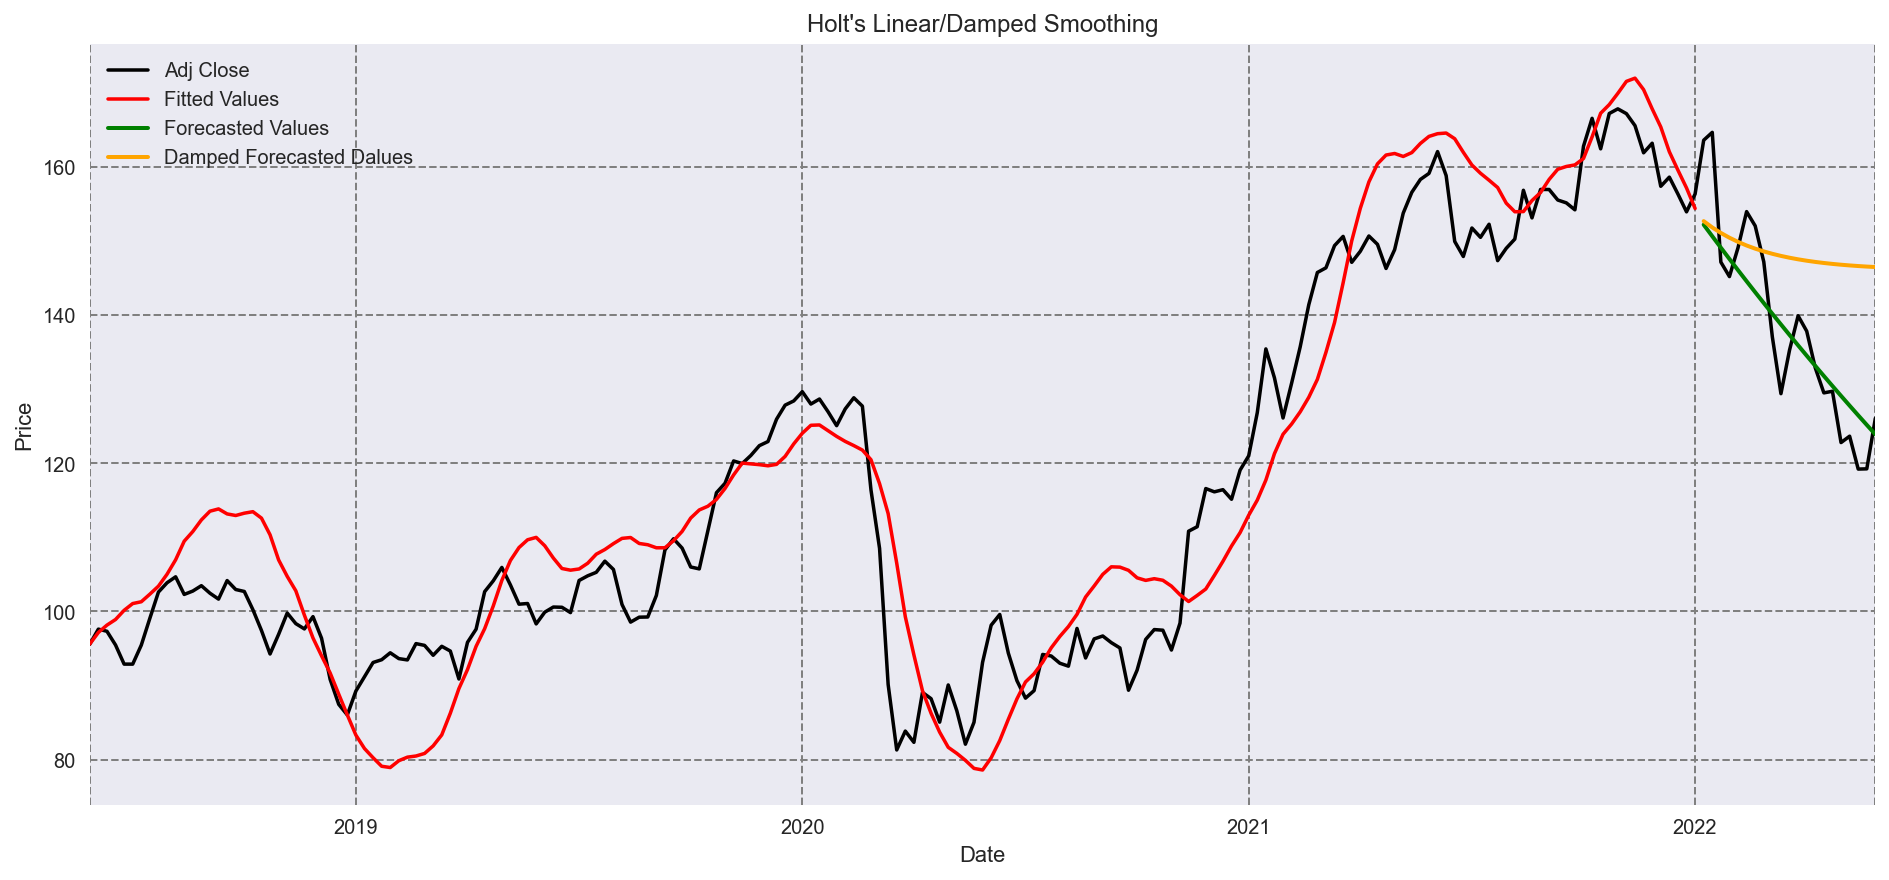

In [41]:
jpm_week_data.plot(color='k',
          title="Holt's Linear/Damped Smoothing",
          legend=True,figsize = (16,7))

model_1.fittedvalues.plot(color='r', label = 'Fitted Values', legend = True)
yhat_1.plot(color='g', legend=True, label='Forecasted Values', lw = 2.0)
yhat_2.plot(color = 'orange', legend = True, label = 'Damped Forecasted Dalues', lw = 2.0)



plt.ylabel('Price')
plt.grid(linestyle = '--', c = 'grey');

From the graph, we can see that the double exponential smoothing performed significantly better than simple exponential smoothing. Holt's Linear Smoothing performs better than when we add a damped parameter.

### Triple Exponencial Smoothing

In [42]:
seasonal_periods = 52
# Holt-Winter's model with exponential trend
hw_1 = ExponentialSmoothing(train_data_es, 
                            trend='mul', 
                            seasonal='add', 
                            seasonal_periods = seasonal_periods, damped = False).fit()
hw_forecast_1 = hw_1.forecast(len(test_data_es))

# Holt-Winter's model with exponential trend and damping
hw_2 = ExponentialSmoothing(train_data_es, 
                            trend='mul', 
                            seasonal='add', 
                            seasonal_periods=seasonal_periods, 
                            damped=True).fit()
hw_forecast_2 = hw_2.forecast(len(test_data_es))

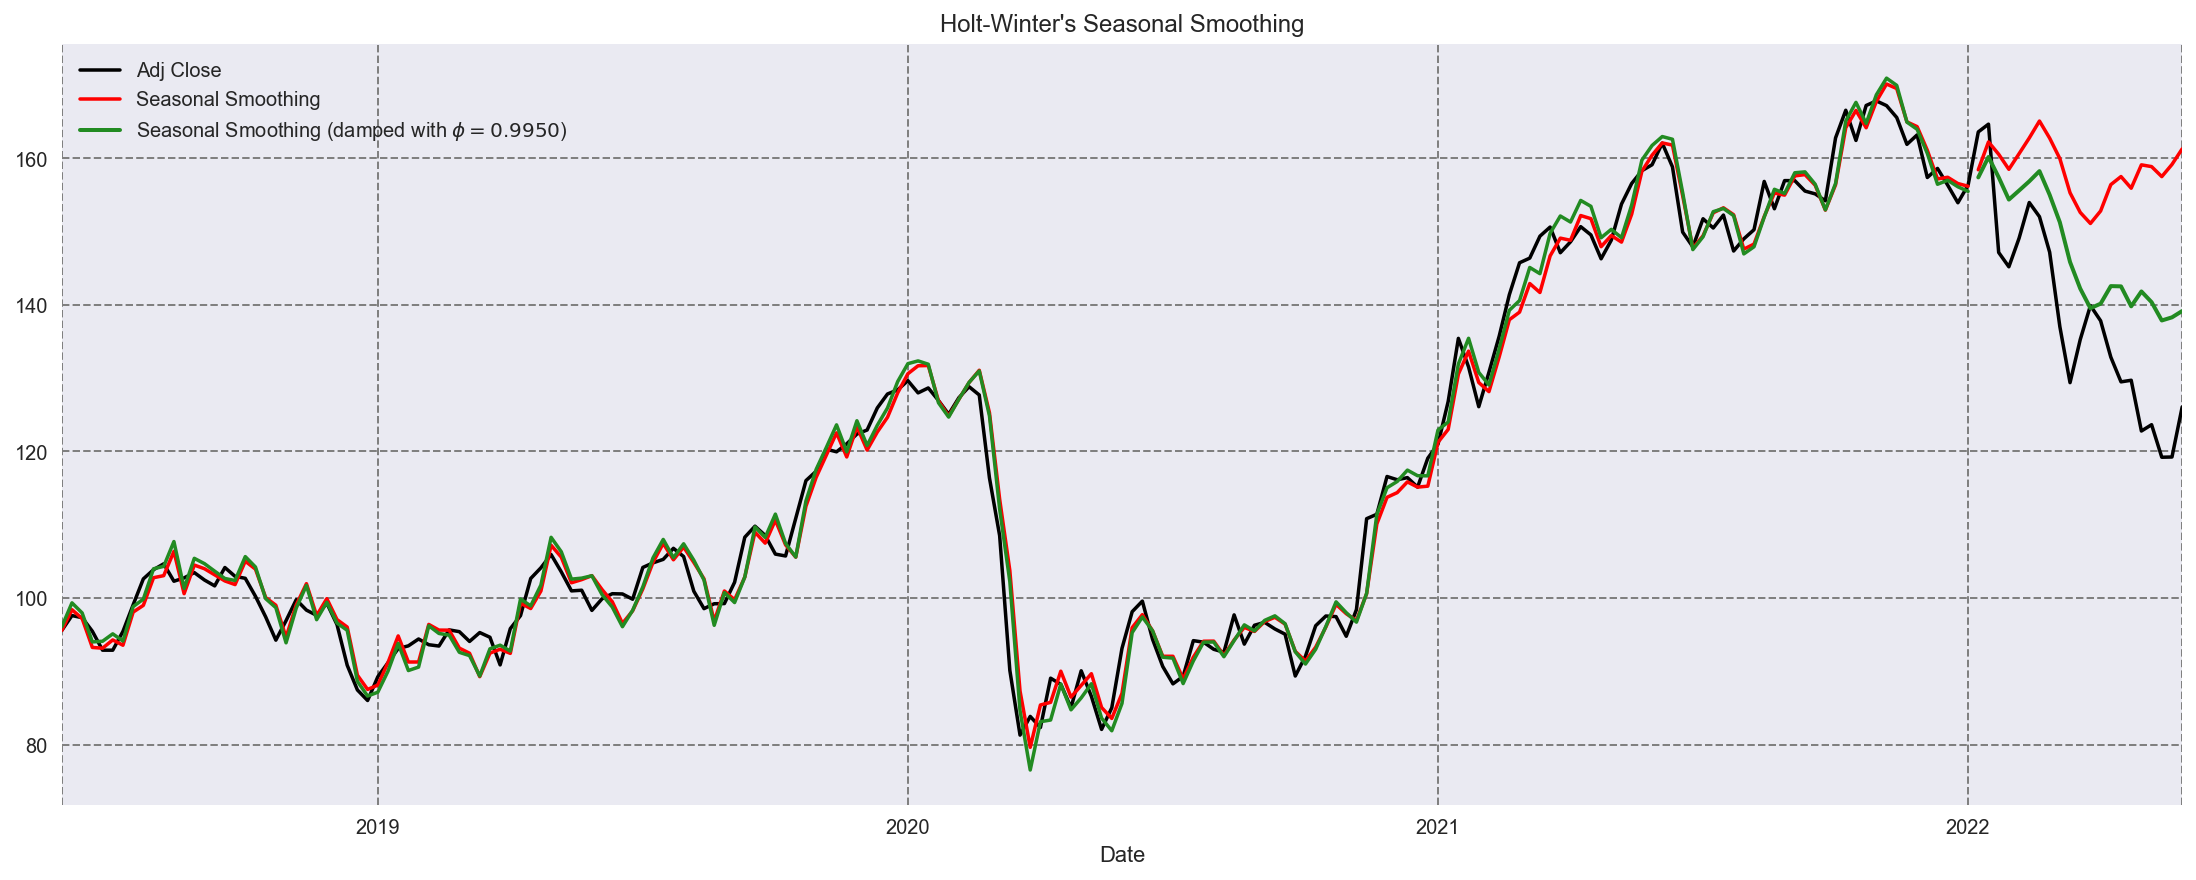

In [43]:
jpm_week_data.plot(color='k',
          title="Holt-Winter's Seasonal Smoothing",
          legend=True, figsize = (19,7))

hw_1.fittedvalues.plot(color='r')
hw_forecast_1.plot(color='r', legend=True, 
                   label='Seasonal Smoothing')

phi = hw_2.model.params['damping_trend']
plot_label = f'Seasonal Smoothing (damped with $\phi={phi:.4f}$)'

hw_2.fittedvalues.plot(color='forestgreen')
hw_forecast_2.plot(color='forestgreen', legend=True, 
                   label=plot_label, lw = 2.0)
plt.grid(linestyle = '--', c = 'grey');

## AR, MA, ARIMA models

In [44]:
# Augmented Dickey-Fuller  unit root test
def ADF_test(data):
    """
    Perform Augmented Dickey-Fuller Test
    The number of considered lags is automatically selected based 
    on the Akaike Information Criterion (AIC)
    Ho = Null Hypothesis -> The data are not stationary
    H1 = Alternate Hypotesis -> The data are stationary
    """
    
    result  = adfuller(data, autolag = 'AIC')
    print(f'ADF Statistic:{result[0]}')
    print (f'P-value: {result[1]}')
    print('Critical Values:')
    for x, y in result[4].items():
        print(f'{x} : {y}')
    if result[1] > 0.05:
        print('We accept the Null Hypotesis. Data are not stationary!')
    else:
        print('We accept the Alternate Hypotesis. Data are Stationary!')

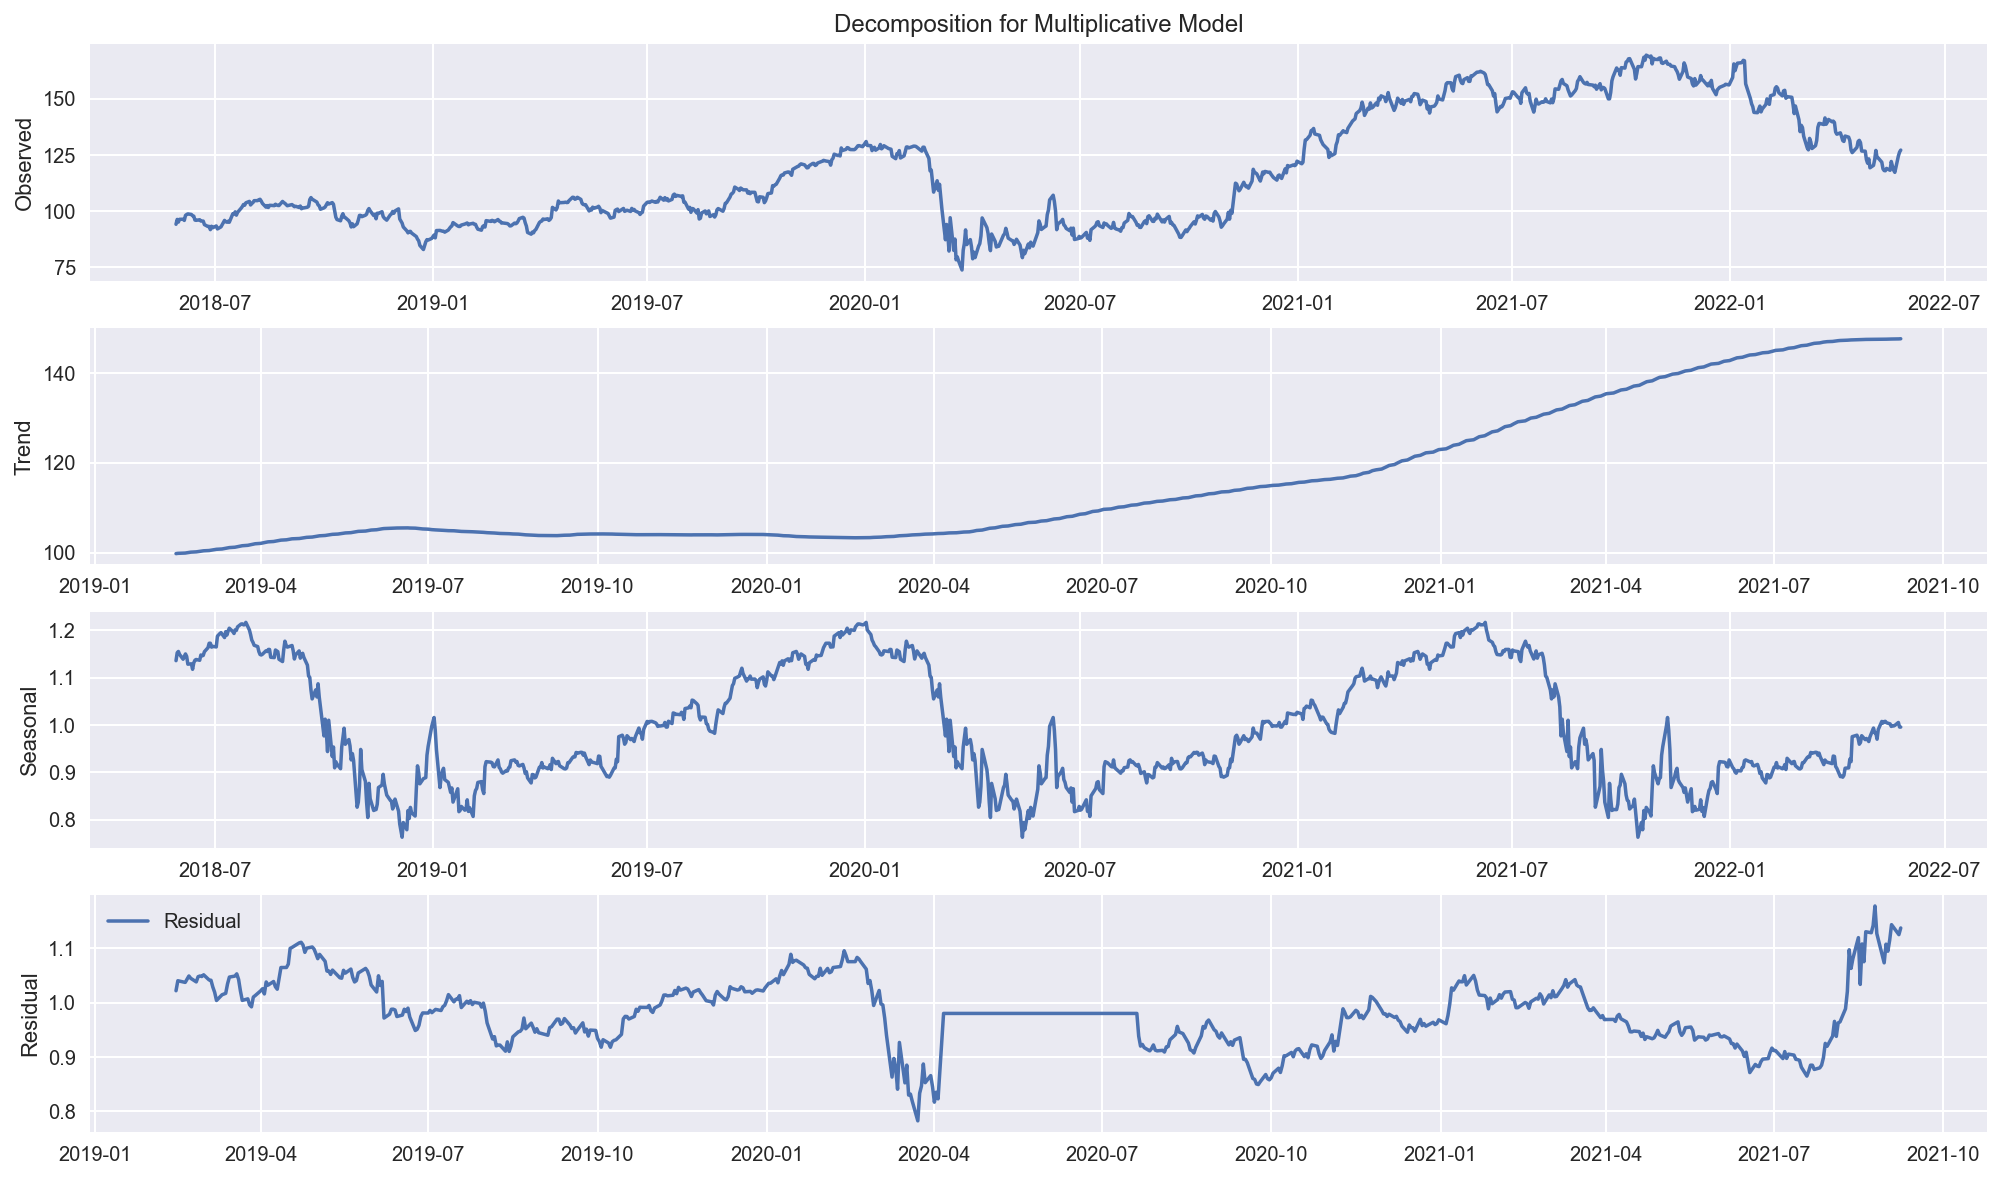

In [45]:
adj_close_price_jpm = jpm_stock_data['Adj Close'].to_frame().copy()
decomposed_jpm_close_price = seasonal_decompose(adj_close_price_jpm, period=360, model = 'multiplicative')

fig, ax = plt.subplots(4,1,figsize =(17,10))
ax[0].plot(decomposed_jpm_close_price.observed)
ax[0].set_ylabel('Observed')
ax[0].set_title('Decomposition for Multiplicative Model')

ax[1].plot(decomposed_jpm_close_price.trend)
ax[1].set_ylabel('Trend')

ax[2].plot(decomposed_jpm_close_price.seasonal, label = 'Seasonal')
ax[2].set_ylabel('Seasonal')

ax[3].plot(decomposed_jpm_close_price.resid, label = 'Residual')
ax[3].set_ylabel('Residual')

plt.legend()
plt.show()

Given the decomposition of the data set we can observe the presence of a polynomial trendand additive seasonality. In the residual plot the data seems to be random, no evidence of patterns.

### Moving Average

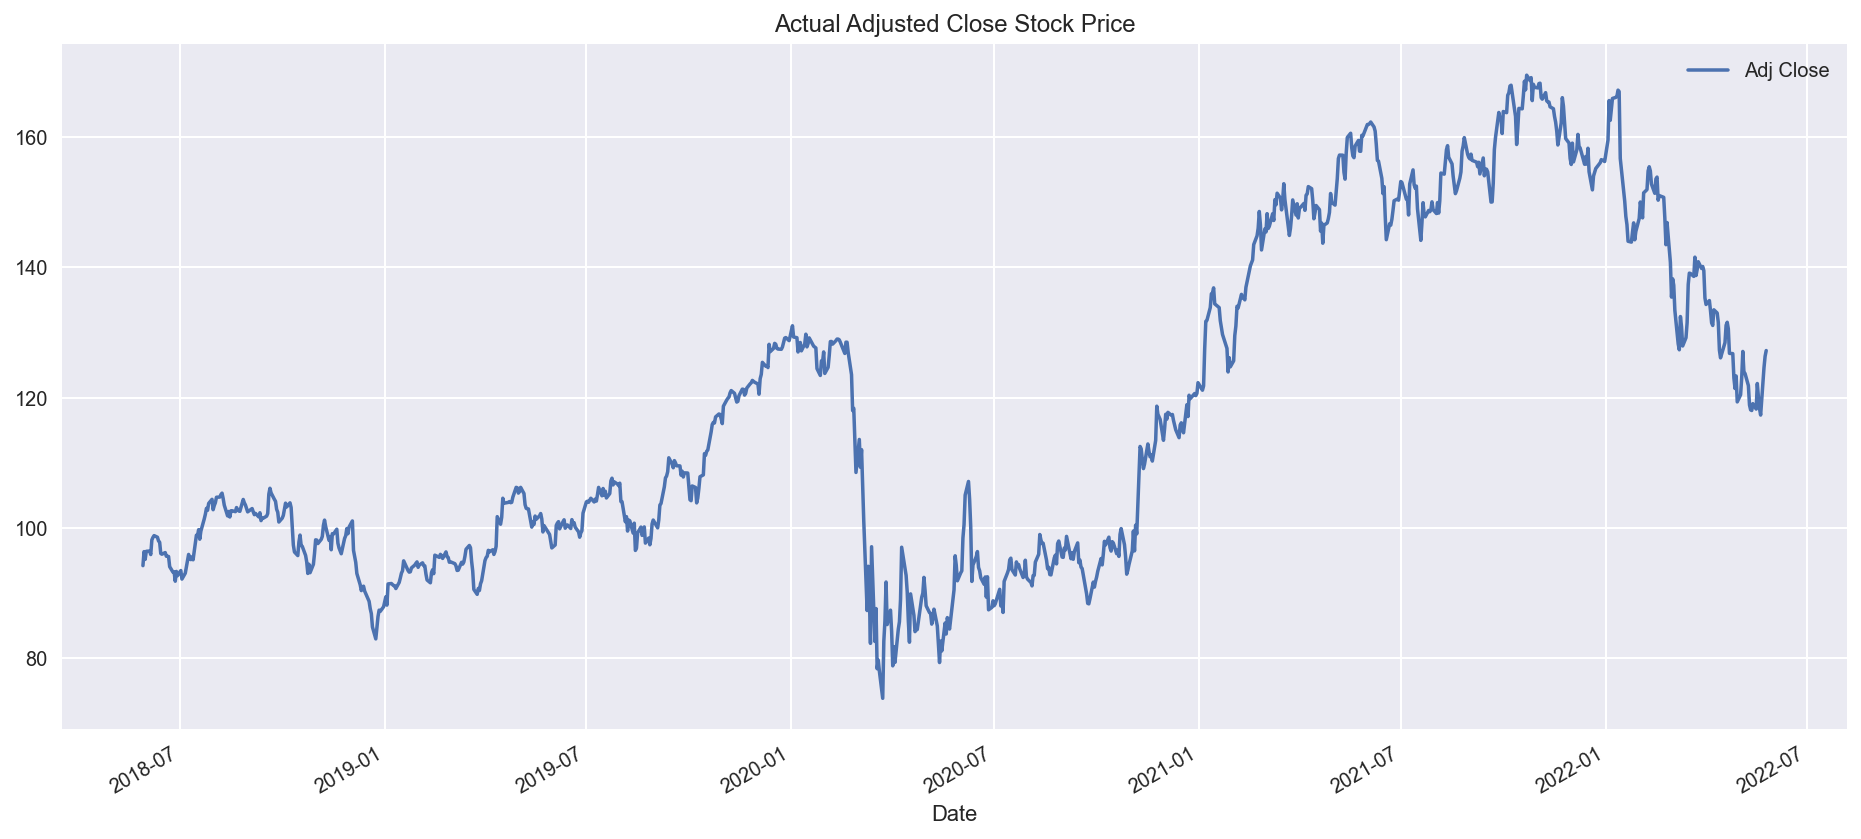

In [46]:
#indentification
adj_close_price_jpm.plot(title = 'Actual Adjusted Close Stock Price', figsize = (16,7));

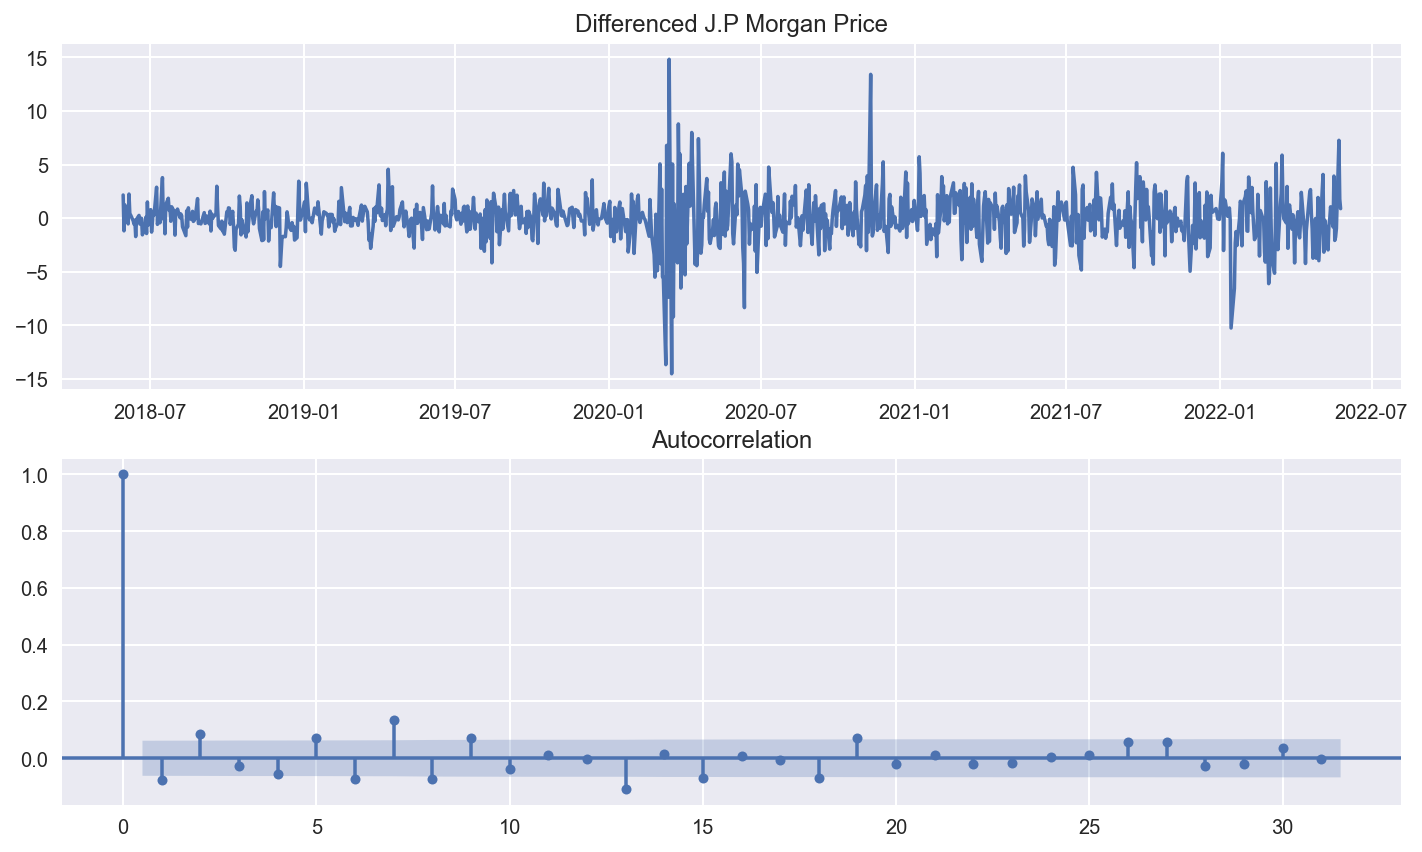

In [47]:
#different the data and plot ACF since it used to find the order of MA
diff_data = adj_close_price_jpm.diff(1).dropna()
fig, ax = plt.subplots(2,1, figsize = (12,7), )
ax[0].plot(diff_data)
ax[0].set_title('Differenced J.P Morgan Price')
plot_acf(diff_data, ax = ax[1]);

In [48]:
ADF_test(diff_data)

ADF Statistic:-9.201970027630024
P-value: 1.9908436632371096e-15
Critical Values:
1% : -3.4369525024039884
5% : -2.8644550095200705
10% : -2.568322093455802
We accept the Alternate Hypotesis. Data are Stationary!


In [49]:
#splitting data into train (95%) and test (5%)
split = int(len(diff_data.values)*0.95)
diff_train_data = diff_data[:split]
diff_test_data = diff_data[split:]

In [50]:
short_moving_average = diff_train_data.rolling(window = 7).mean()
long_moving_average = diff_train_data.rolling (window = 19).mean()


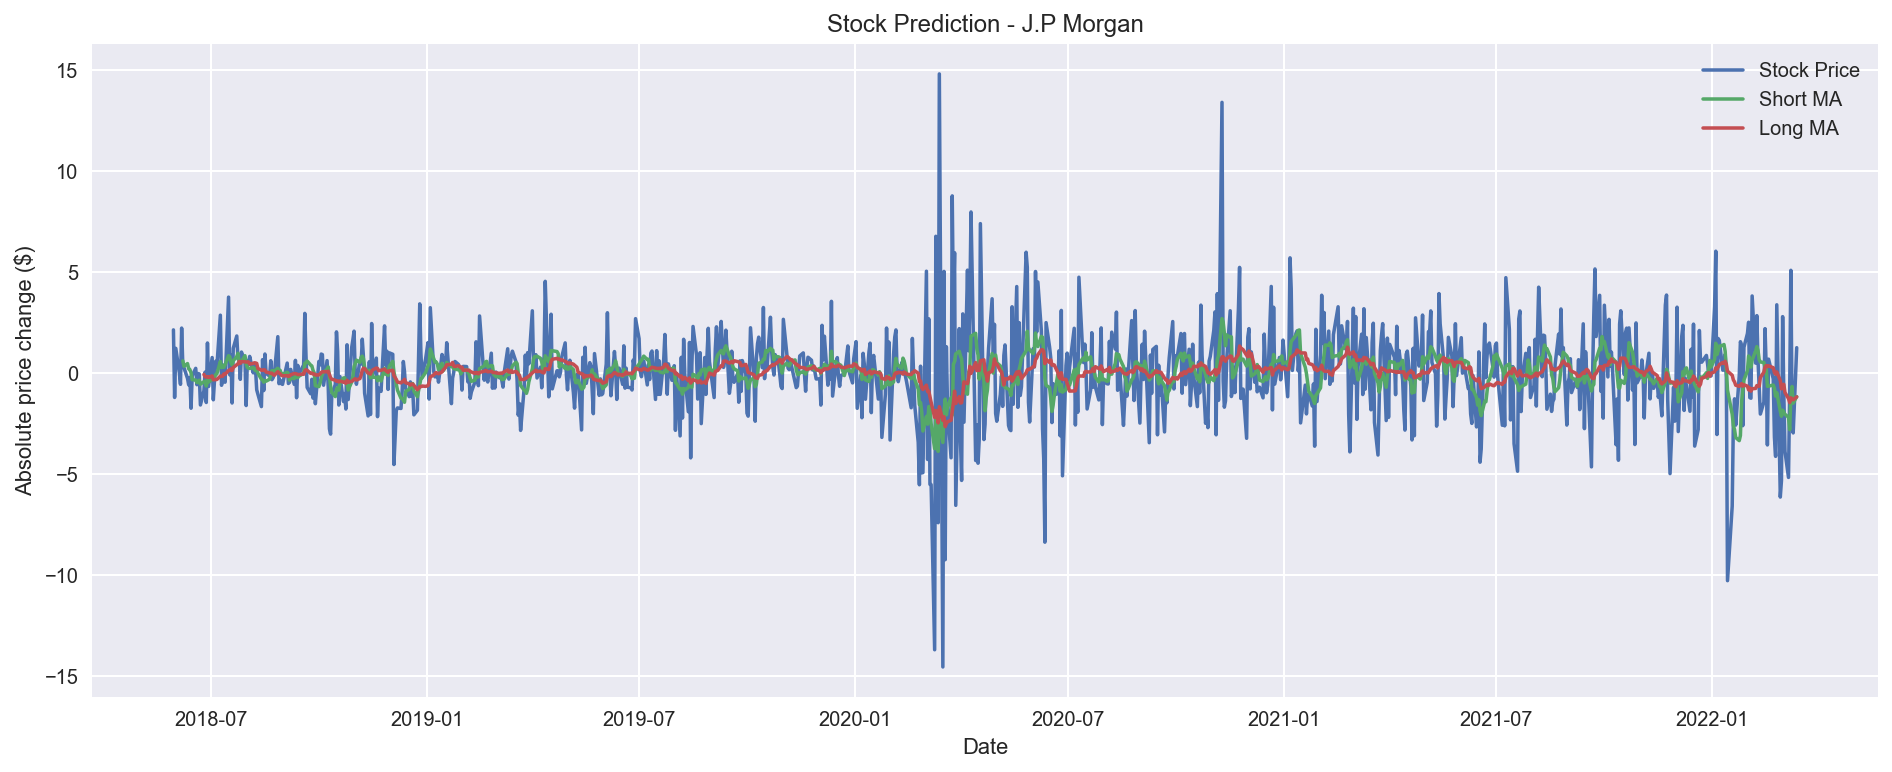

In [51]:
fig, ax = plt.subplots(1,1,figsize = (16,6))
ax.plot(diff_train_data.index, diff_train_data.values, label = 'Stock Price')
ax.plot(short_moving_average.index, short_moving_average, label = 'Short MA')
ax.plot(long_moving_average.index, long_moving_average, label = 'Long MA')
ax.legend(loc = 'best')
ax.set_title('Stock Prediction - J.P Morgan')
ax.set_xlabel('Date')
ax.set_ylabel('Absolute price change ($)')
plt.legend()
plt.show()

Short-term MA tends to be more responsive to daily changes in J.P Morgan's stock price compared to the long-term MA, this is because I am taking into account just seven lags, and this means that just seven previous errors are accounted for to predict the actual data point.

## Autoregressive Model

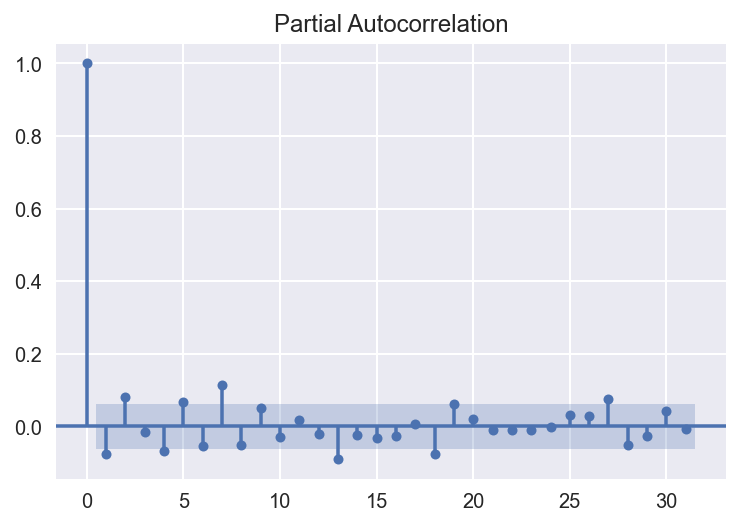

In [52]:
from statsmodels.tsa.ar_model import AutoReg
plot_pacf(diff_data);

In [53]:
ar_jpm = AutoReg(diff_train_data.values, lags = 27)
ar_fitted_jpm = ar_jpm.fit() #fitting stock data with AR model
#predicting the stock prices
ar_predictions_jpm = ar_fitted_jpm.predict(start = len(diff_train_data), 
                                           end = len(diff_train_data)+len(diff_test_data)-1, dynamic=False) 

In [54]:
ar_predictions_jpm = pd.DataFrame(ar_predictions_jpm) #turning the array into a dataframe 
ar_predictions_jpm.set_index(diff_test_data.index, inplace = True)

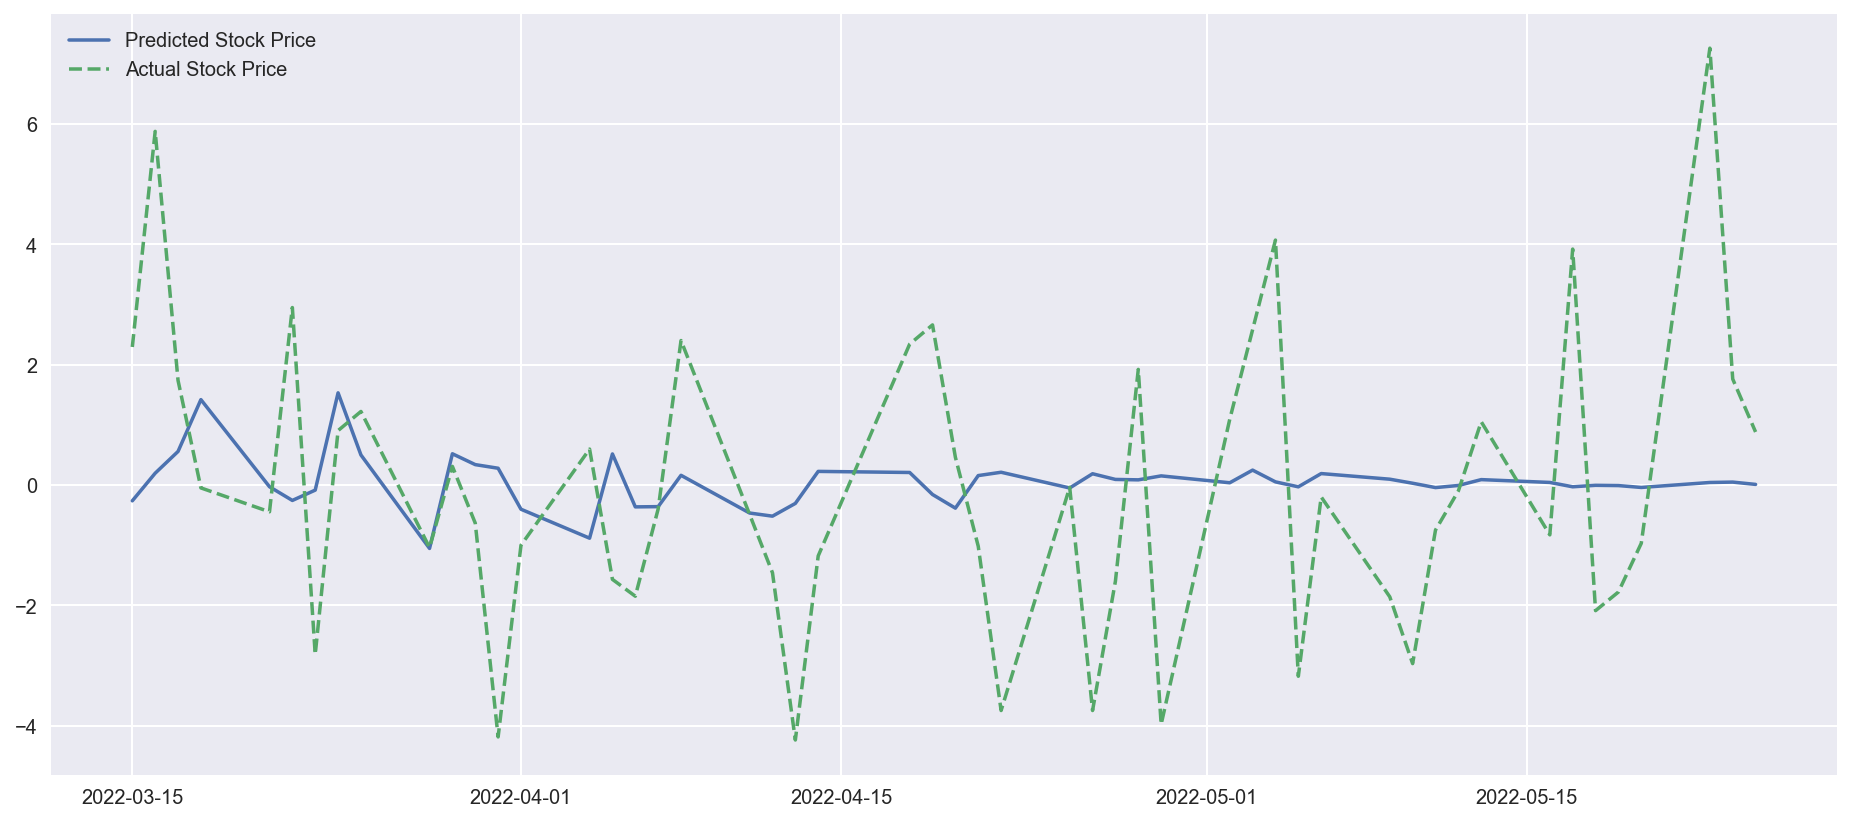

In [55]:
fig, ax = plt.subplots(1,1, figsize = (16,7))
ax.plot(ar_predictions_jpm, label = 'Predicted Stock Price')
ax.plot(diff_test_data, label = 'Actual Stock Price', ls = '--')
plt.legend()
plt.show()

We can observe that the prediction based on the AR model doesn't have a good performance, and I conclude that the MA model outperforms the AR model in capturing the stock price.

### Autoregressive Integrated Moving Average (ARIMA)
ARIMA has three parameters:
* p - AR order
* d - level of differencing
* q - MA order

In [57]:
split = int(len(adj_close_price_jpm)*0.90)
train_data  = adj_close_price_jpm.iloc[:split]
test_data  = adj_close_price_jpm.iloc[split:]

In [58]:
#find the optimal number of differencing
from pmdarima.arima.utils import ndiffs
number_of_diff = ndiffs(train_data, test = 'adf')
print(f'Number of differencing: {number_of_diff}')

Number of differencing: 1


To find the optimum number of lags to use in the ARIMA model, we need to choose an order that minimizes the AIC value.
I will use auto ARIMA to achieve this.

In [59]:
#start_p -> the order of the auto-regressive (“AR”) model
#start_q-> the starting value of q, the order of the moving-average (“MA”) model.
#m -> the number of periods in each season
model = auto_arima(train_data, start_p=1, start_q=1, max_p=3, max_q=3,
                   m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,
                   error_action='ignore',
                   test = 'adf',
                   information_criterion='aic',suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.42 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4510.381, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4262.658, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.35 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4505.850, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4151.118, Time=0.60 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=4.36 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.40 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4159.347, Time=0.39 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4139.209, Time=0.69 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4252.381, Time=0.35 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=5.54 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.38 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4136.905, Time=0.91 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=4251.2

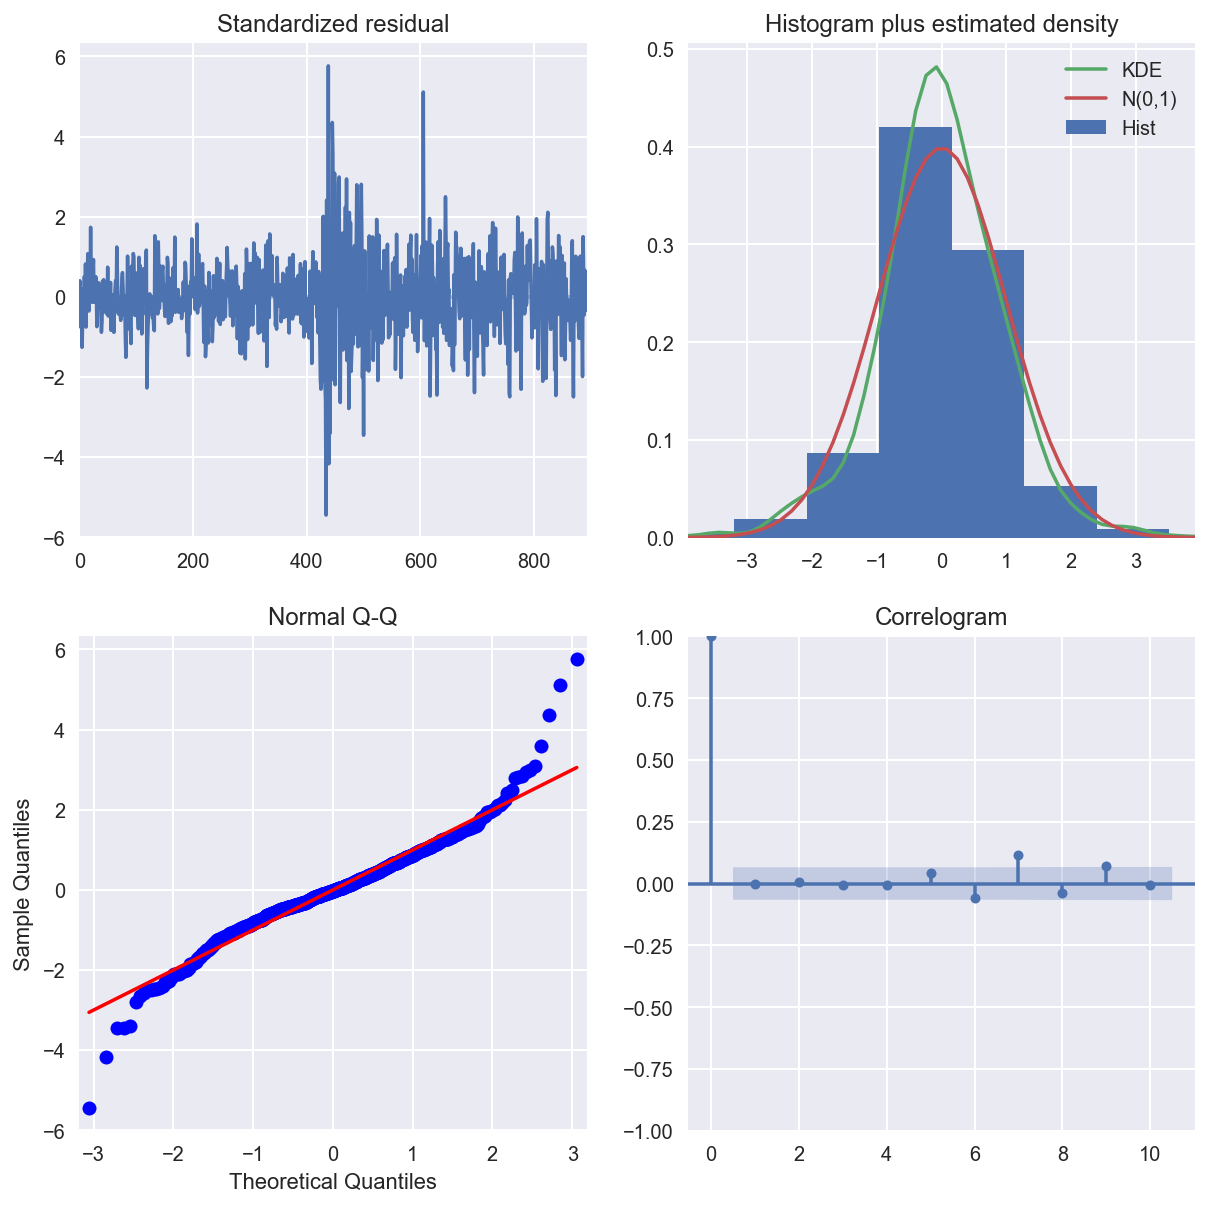

In [60]:
#residuals to check their normality 
output = model.plot_diagnostics(figsize=(10,10))

Notice how the normal Q-Q plot and the histogram show that our residuals follow a normal distribution. The correlogram also shows that the residuals are uncorrelated !

In [61]:
auto_arima_fitted = model.fit(train_data)

In [62]:
auto_arima_prediction_jpm = auto_arima_fitted.predict(len(test_data))

In [63]:
auto_arima_prediction_jpm = pd.DataFrame(auto_arima_prediction_jpm, index = test_data.index)

In [64]:
rms = sqrt(mean_squared_error(test_data, auto_arima_prediction_jpm))
print("RMSE: ", rms)

RMSE:  7.77388647099585


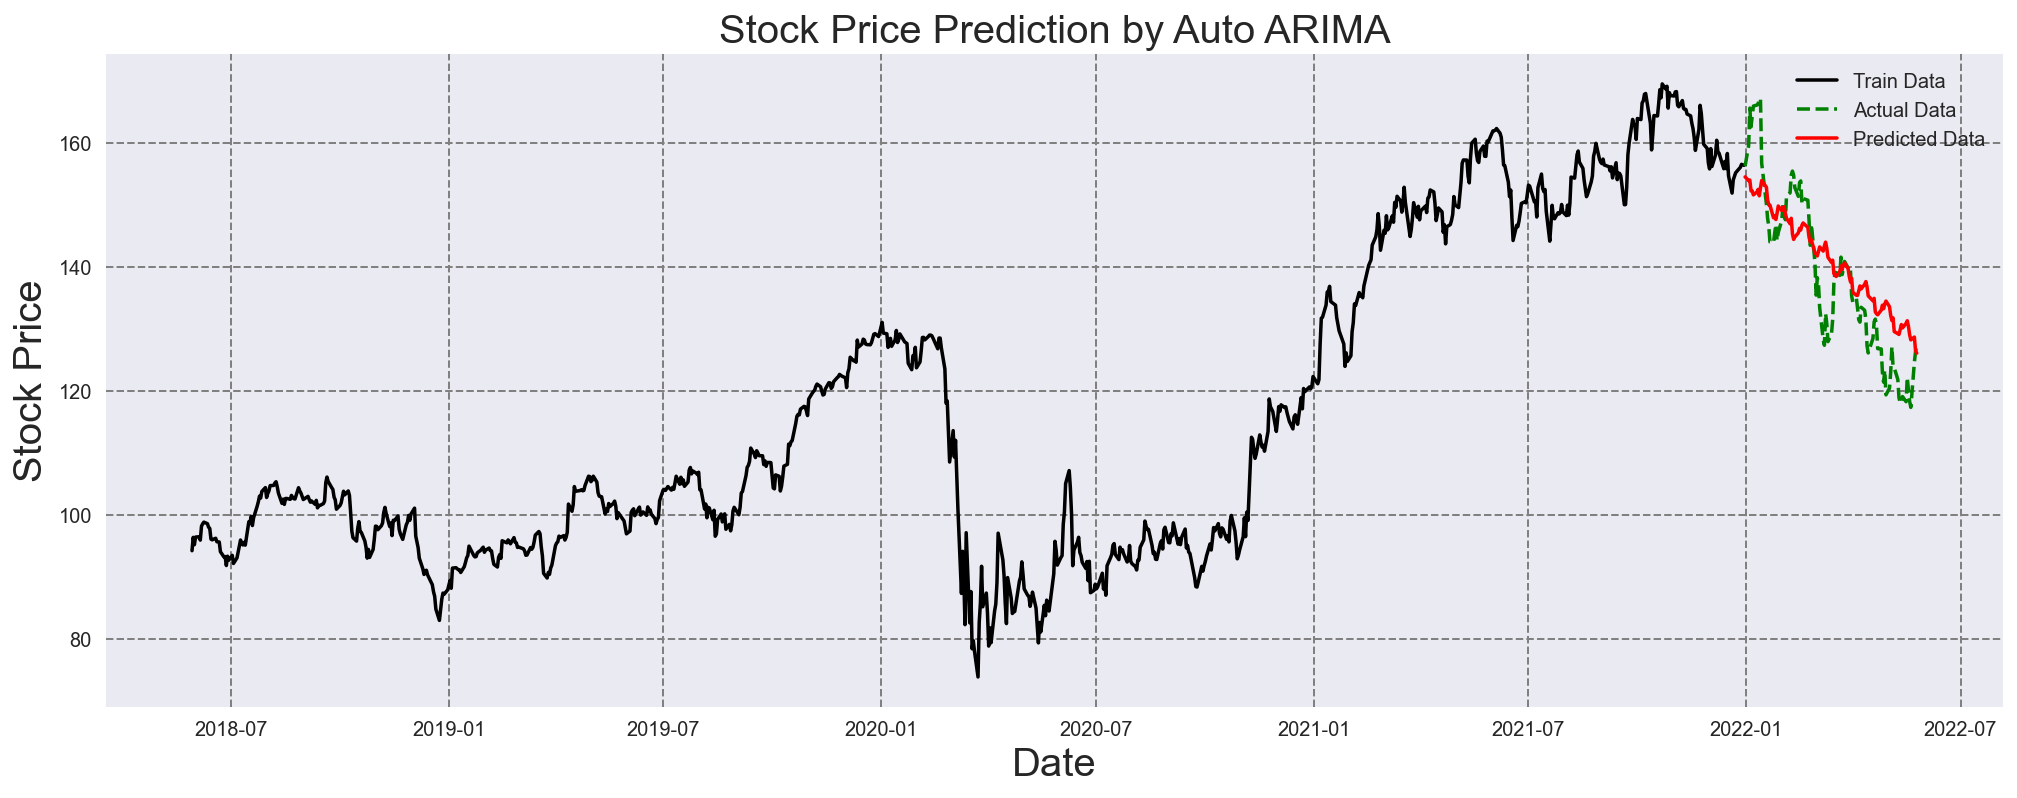

In [65]:
plt.figure(figsize = (17,6))
plt.plot(train_data, c = 'k')
plt.plot(test_data, c = 'g', ls = '--')
plt.plot(auto_arima_prediction_jpm, c = 'red')
plt.xlabel('Date',size=20)
plt.ylabel('Stock Price',size=20)
plt.title('Stock Price Prediction by Auto ARIMA',size=20)
plt.legend(['Train Data','Actual Data','Predicted Data'])
plt.grid(linestyle = '--', c = 'grey')

### Long Short Term Memory (LSTM)

LSTMs are widely used for sequence prediction problems and have proven to be extremely effective. The reason they work so well is because LSTM is able to store past information that is important, and forget the information that is not. LSTM has three gates:

* The input gate: The input gate adds information to the cell state
* The forget gate: It removes the information that is no longer required by the model
* The output gate: Output Gate at LSTM selects the information to be shown as output

In [66]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [67]:
#take data
dataset = jpm_stock_data['Adj Close'].copy().to_frame()
#create train and test data
train_data  = jpm_stock_data['Adj Close'].iloc[:int(jpm_stock_data['Adj Close'].shape[0]*0.90)].dropna().to_frame()
test_data  = jpm_stock_data['Adj Close'].iloc[int(jpm_stock_data['Adj Close'].shape[0]*0.90):].dropna().to_frame()

In [68]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [69]:
x_train, y_train = [], []
for i in range(60,len(train_data)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

In [70]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [72]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

846/846 - 18s - loss: 0.0039 - 18s/epoch - 22ms/step


In [73]:
#predicting values, using past 60 from the train data
inputs = dataset[len(dataset) - len(test_data) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [74]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [75]:
rms=np.sqrt(np.mean(np.power((test_data-closing_price),2)))
rms

Adj Close    5.509576
dtype: float64

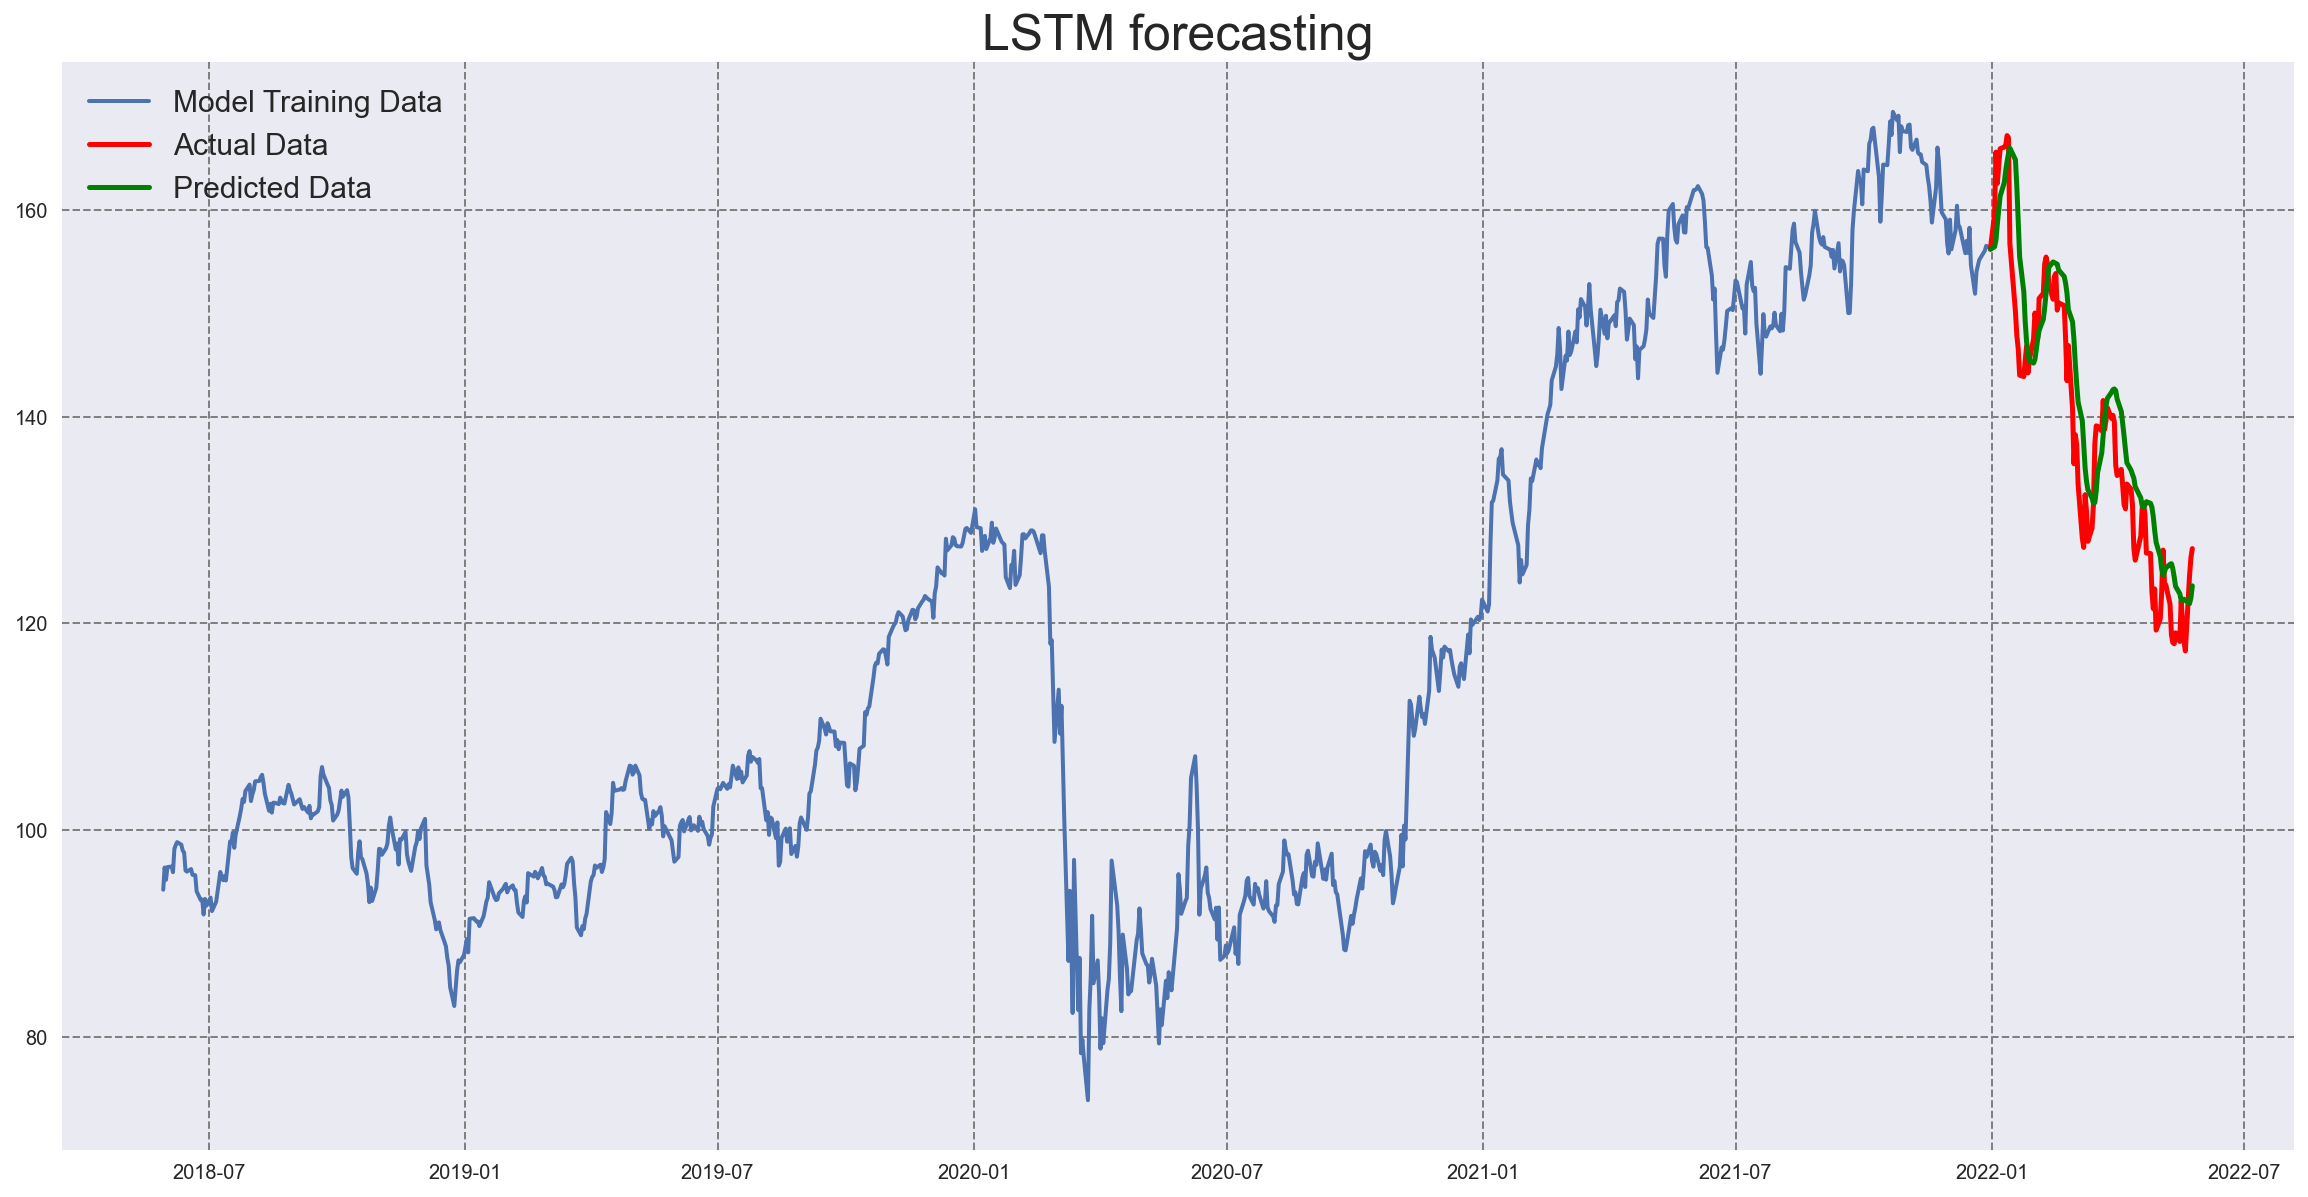

In [76]:
#plotting
test_data['Predictions'] = closing_price

plt.figure(figsize = (20,10))
plt.plot(train_data,lw = 2.0, label = 'Model Training Data')
plt.plot(test_data['Adj Close'],lw = 2.5, label = 'Actual Data', c = 'r')
plt.plot(test_data['Predictions'],lw = 2.5, label = 'Predicted Data', c = 'g')
plt.title('LSTM forecasting', fontdict={'fontsize': 25})
plt.grid(linestyle = '--', c = 'grey')
plt.legend(loc = 'upper left', fontsize= 15)
plt.show()